##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


# 加载视频数据

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/tutorials/load_data/video"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a> </td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/load_data/video.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行</a></td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/load_data/video.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 上查看源代码</a>
</td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/load_data/video.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a> </td>
</table>

本教程演示如何使用 [UCF101 人体动作数据集](https://en.wikipedia.org/wiki/Audio_Video_Interleave)加载和预处理 [AVI](https://tensorflow.google.cn/datasets/catalog/ucf101) 视频数据。当您对数据进行预处理后，就可以将其用于视频分类/识别、字幕或聚类等任务。原始数据集包含从 YouTube 收集的具有 101 个类别的真实动作视频，包括演奏大提琴、刷牙和化眼妆。您将学习如何：

- 从 ZIP 文件加载数据。

- 从视频文件中读取帧序列。

- 呈现视频数据。

- 封装帧生成器 [`tf.data.Dataset`](https://tensorflow.google.cn/guide/data)。

本视频加载和预处理教程是 TensorFlow 视频教程系列的第一部分。下面是其他三个教程：

- [构建用于视频分类的 3D CNN 模型](https://tensorflow.google.cn/tutorials/video/video_classification)：请注意，本教程使用分解 3D 数据的空间和时间方面的 (2+1)D CNN；如果使用 MRI 扫描等体数据，请考虑使用 3D CNN 而不是 (2+1)D CNN。
- [用于流式动作识别的 MoViNet](https://tensorflow.google.cn/hub/tutorials/movinet)：熟悉 TF Hub 上提供的 MoViNet 模型。
- [使用 MoViNet 进行视频分类的迁移学习](https://tensorflow.google.cn/tutorials/video/transfer_learning_with_movinet)：本教程介绍了如何使用预训练的视频分类模型，该模型是在具有 UCF-101 数据集的不同数据集上训练的。

## 安装

首先，安装和导入一些必要的库，包括：用于检查 ZIP 文件内容的 [remotezip](https://github.com/gtsystem/python-remotezip)，用于使用进度条的 [tqdm](https://github.com/tqdm/tqdm)，用于处理视频文件的 [OpenCV](https://opencv.org/)，以及用于在 Jupyter 笔记本中嵌入数据的 [`tensorflow_docs`](https://github.com/tensorflow/docs/tree/master/tools/tensorflow_docs)。

In [2]:
# The way this tutorial uses the `TimeDistributed` layer requires TF>=2.10
!pip install -U "tensorflow>=2.10.0"

In [3]:
!pip install remotezip tqdm opencv-python
!pip install -q git+https://github.com/tensorflow/docs

  Using cached remotezip-0.12.1-py3-none-any.whl


  Using cached opencv_python-4.8.1.78-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)


  Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)


Using cached opencv_python-4.8.1.78-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (61.7 MB)


In [4]:
import tqdm
import random
import pathlib
import itertools
import collections

import os
import cv2
import numpy as np
import remotezip as rz

import tensorflow as tf

# Some modules to display an animation using imageio.
import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed

2023-11-07 23:37:06.494330: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 23:37:06.494378: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 23:37:06.496111: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 下载 UCF101 数据集的子集

[UCF101 数据集](https://tensorflow.google.cn/datasets/catalog/ucf101)包含 101 类不同动作的视频，主要用于动作识别。您将在此演示中使用这些类别的一个子集。

In [5]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'

上面的网址包含一个带有 UCF 101 数据集的 ZIP 文件。创建一个使用 `remotezip` 库的函数来检查该 URL 中 ZIP 文件的内容：

In [6]:
def list_files_from_zip_url(zip_url):
  """ List the files in each class of the dataset given a URL with the zip file.

    Args:
      zip_url: A URL from which the files can be extracted from.

    Returns:
      List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(zip_url) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

In [7]:
files = list_files_from_zip_url(URL)
files = [f for f in files if f.endswith('.avi')]
files[:10]

['UCF101/v_ApplyEyeMakeup_g01_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c04.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c05.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c06.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c04.avi']

先从几个视频和有限数量的类开始训练。运行上述代码块后，请注意类名包含在每个视频的文件名中。

定义从文件名中检索类名的 `get_class` 函数。然后，创建一个名为 `get_files_per_class` 的函数，它会将所有文件的列表（上面的 `files`）转换为列出每个类的文件的字典：

In [8]:
def get_class(fname):
  """ Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Returns:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]

In [9]:
def get_files_per_class(files):
  """ Retrieve the files that belong to each class.

    Args:
      files: List of files in the dataset.

    Returns:
      Dictionary of class names (key) and files (values). 
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

获得每个类的文件列表后，您可以选择要使用多少个类，以及每个类需要多少视频，以创建数据集。 

In [10]:
NUM_CLASSES = 10
FILES_PER_CLASS = 50

In [11]:
files_for_class = get_files_per_class(files)
classes = list(files_for_class.keys())

In [12]:
print('Num classes:', len(classes))
print('Num videos for class[0]:', len(files_for_class[classes[0]]))

Num classes: 101
Num videos for class[0]: 145


创建一个名为 `select_subset_of_classes` 的新函数，它会选择数据集中存在的类的子集并在每个类中选择特定数量的文件：

In [13]:
def select_subset_of_classes(files_for_class, classes, files_per_class):
  """ Create a dictionary with the class name and a subset of the files in that class.

    Args:
      files_for_class: Dictionary of class names (key) and files (values).
      classes: List of classes.
      files_per_class: Number of files per class of interest.

    Returns:
      Dictionary with class as key and list of specified number of video files in that class.
  """
  files_subset = dict()

  for class_name in classes:
    class_files = files_for_class[class_name]
    files_subset[class_name] = class_files[:files_per_class]

  return files_subset

In [14]:
files_subset = select_subset_of_classes(files_for_class, classes[:NUM_CLASSES], FILES_PER_CLASS)
list(files_subset.keys())

['ApplyEyeMakeup',
 'ApplyLipstick',
 'Archery',
 'BabyCrawling',
 'BalanceBeam',
 'BandMarching',
 'BaseballPitch',
 'BasketballDunk',
 'Basketball',
 'BenchPress']

定义将视频拆分为训练集、验证集和测试集的辅助函数。视频从带有 ZIP 文件的网址下载，并放置在各自的子目录中。

In [15]:
def download_from_zip(zip_url, to_dir, file_names):
  """ Download the contents of the zip file from the zip URL.

    Args:
      zip_url: A URL with a zip file containing data.
      to_dir: A directory to download data to.
      file_names: Names of files to download.
  """
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file)

以下函数会返回尚未放入数据子集的剩余数据。它允许您将剩余的数据放在下一个指定的数据子集中。

In [16]:
def split_class_lists(files_for_class, count):
  """ Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.
    
    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Returns:
      Files belonging to the subset of data and dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

下面的 `download_ufc_101_subset` 函数允许您下载 UCF101 数据集的子集并将其拆分为训练集、验证集和测试集。您可以指定要使用的类的数量。`splits` 参数允许您传入一个字典，其中键值是子集的名称（例如：“train”）和您希望每个类拥有的视频数量。

In [17]:
def download_ucf_101_subset(zip_url, num_classes, splits, download_dir):
  """ Download a subset of the UCF101 dataset and split them into various parts, such as
    training, validation, and test.

    Args:
      zip_url: A URL with a ZIP file with the data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data 
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      Mapping of the directories containing the subsections of data.
  """
  files = list_files_from_zip_url(zip_url)
  for f in files:
    path = os.path.normpath(f)
    tokens = path.split(os.sep)
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename
  
  files_for_class = get_files_per_class(files)

  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    random.shuffle(files_for_class[cls])
    
  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in classes}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

In [18]:
download_dir = pathlib.Path('./UCF101_subset/')
subset_paths = download_ucf_101_subset(URL,
                                       num_classes = NUM_CLASSES,
                                       splits = {"train": 30, "val": 10, "test": 10},
                                       download_dir = download_dir)

train :


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 1/300 [00:00<01:07,  4.43it/s]

  1%|          | 2/300 [00:00<00:54,  5.49it/s]

  1%|          | 3/300 [00:00<00:56,  5.27it/s]

  1%|▏         | 4/300 [00:00<00:50,  5.85it/s]

  2%|▏         | 6/300 [00:00<00:41,  7.09it/s]

  3%|▎         | 8/300 [00:01<00:38,  7.63it/s]

  3%|▎         | 9/300 [00:01<00:40,  7.27it/s]

  3%|▎         | 10/300 [00:01<00:43,  6.71it/s]

  4%|▍         | 12/300 [00:01<00:41,  6.94it/s]

  5%|▍         | 14/300 [00:02<00:36,  7.76it/s]

  5%|▌         | 16/300 [00:02<00:34,  8.23it/s]

  6%|▌         | 18/300 [00:02<00:31,  9.10it/s]

  6%|▋         | 19/300 [00:02<00:31,  8.97it/s]

  7%|▋         | 20/300 [00:02<00:30,  9.12it/s]

  7%|▋         | 21/300 [00:02<00:30,  9.15it/s]

  8%|▊         | 23/300 [00:02<00:28,  9.61it/s]

  8%|▊         | 24/300 [00:03<00:30,  8.98it/s]

  8%|▊         | 25/300 [00:03<00:32,  8.52it/s]

  9%|▉         | 27/300 [00:03<00:27,  9.76it/s]

 10%|▉         | 29/300 [00:03<00:25, 10.53it/s]

 10%|█         | 31/300 [00:03<00:26, 10.03it/s]

 11%|█         | 33/300 [00:03<00:25, 10.28it/s]

 12%|█▏        | 35/300 [00:04<00:26,  9.97it/s]

 12%|█▏        | 37/300 [00:04<00:24, 10.67it/s]

 13%|█▎        | 39/300 [00:04<00:23, 11.15it/s]

 14%|█▎        | 41/300 [00:04<00:21, 11.81it/s]

 14%|█▍        | 43/300 [00:04<00:21, 11.81it/s]

 15%|█▌        | 45/300 [00:04<00:21, 11.89it/s]

 16%|█▌        | 47/300 [00:05<00:21, 11.66it/s]

 16%|█▋        | 49/300 [00:05<00:20, 12.19it/s]

 17%|█▋        | 51/300 [00:05<00:19, 12.65it/s]

 18%|█▊        | 53/300 [00:05<00:18, 13.23it/s]

 18%|█▊        | 55/300 [00:05<00:17, 13.74it/s]

 19%|█▉        | 57/300 [00:05<00:16, 14.38it/s]

 20%|█▉        | 59/300 [00:05<00:18, 12.92it/s]

 20%|██        | 61/300 [00:06<00:21, 11.23it/s]

 21%|██        | 63/300 [00:06<00:23,  9.99it/s]

 22%|██▏       | 65/300 [00:06<00:21, 11.02it/s]

 22%|██▏       | 67/300 [00:07<00:35,  6.65it/s]

 23%|██▎       | 68/300 [00:07<00:33,  6.83it/s]

 23%|██▎       | 69/300 [00:07<00:33,  6.92it/s]

 24%|██▎       | 71/300 [00:07<00:27,  8.19it/s]

 24%|██▍       | 72/300 [00:07<00:34,  6.68it/s]

 24%|██▍       | 73/300 [00:08<00:34,  6.57it/s]

 25%|██▍       | 74/300 [00:08<00:34,  6.52it/s]

 25%|██▌       | 75/300 [00:08<00:32,  6.83it/s]

 25%|██▌       | 76/300 [00:08<00:35,  6.30it/s]

 26%|██▌       | 78/300 [00:08<00:28,  7.89it/s]

 27%|██▋       | 80/300 [00:08<00:23,  9.19it/s]

 27%|██▋       | 81/300 [00:08<00:25,  8.51it/s]

 27%|██▋       | 82/300 [00:09<00:31,  6.89it/s]

 28%|██▊       | 84/300 [00:09<00:27,  7.84it/s]

 29%|██▊       | 86/300 [00:09<00:25,  8.29it/s]

 29%|██▉       | 88/300 [00:09<00:22,  9.60it/s]

 30%|███       | 90/300 [00:10<00:24,  8.57it/s]

 31%|███       | 92/300 [00:10<00:24,  8.64it/s]

 31%|███       | 93/300 [00:10<00:24,  8.55it/s]

 31%|███▏      | 94/300 [00:10<00:28,  7.21it/s]

 32%|███▏      | 95/300 [00:10<00:28,  7.29it/s]

 32%|███▏      | 96/300 [00:10<00:27,  7.32it/s]

 32%|███▏      | 97/300 [00:11<00:27,  7.40it/s]

 33%|███▎      | 98/300 [00:11<00:33,  5.97it/s]

 33%|███▎      | 99/300 [00:11<00:29,  6.70it/s]

 34%|███▎      | 101/300 [00:11<00:29,  6.84it/s]

 34%|███▍      | 103/300 [00:11<00:23,  8.34it/s]

 35%|███▌      | 105/300 [00:11<00:19,  9.90it/s]

 36%|███▌      | 107/300 [00:12<00:18, 10.21it/s]

 36%|███▋      | 109/300 [00:12<00:20,  9.41it/s]

 37%|███▋      | 110/300 [00:12<00:20,  9.34it/s]

 37%|███▋      | 112/300 [00:12<00:18, 10.29it/s]

 38%|███▊      | 114/300 [00:12<00:17, 10.93it/s]

 39%|███▊      | 116/300 [00:13<00:16, 11.15it/s]

 39%|███▉      | 118/300 [00:13<00:17, 10.34it/s]

 40%|████      | 120/300 [00:13<00:17, 10.36it/s]

 41%|████      | 122/300 [00:13<00:18,  9.53it/s]

 41%|████      | 123/300 [00:13<00:21,  8.10it/s]

 41%|████▏     | 124/300 [00:13<00:21,  8.27it/s]

 42%|████▏     | 126/300 [00:14<00:18,  9.44it/s]

 43%|████▎     | 128/300 [00:14<00:15, 10.79it/s]

 43%|████▎     | 130/300 [00:14<00:15, 11.30it/s]

 44%|████▍     | 132/300 [00:14<00:14, 11.59it/s]

 45%|████▍     | 134/300 [00:14<00:13, 12.21it/s]

 45%|████▌     | 136/300 [00:15<00:16,  9.98it/s]

 46%|████▌     | 138/300 [00:15<00:15, 10.43it/s]

 47%|████▋     | 140/300 [00:15<00:15, 10.63it/s]

 47%|████▋     | 142/300 [00:15<00:14, 10.77it/s]

 48%|████▊     | 144/300 [00:15<00:14, 11.05it/s]

 49%|████▊     | 146/300 [00:15<00:15, 10.17it/s]

 49%|████▉     | 148/300 [00:16<00:15,  9.94it/s]

 50%|█████     | 150/300 [00:16<00:16,  9.36it/s]

 50%|█████     | 151/300 [00:16<00:17,  8.49it/s]

 51%|█████     | 152/300 [00:16<00:22,  6.46it/s]

 51%|█████     | 153/300 [00:16<00:21,  6.96it/s]

 51%|█████▏    | 154/300 [00:17<00:20,  7.03it/s]

 52%|█████▏    | 156/300 [00:17<00:24,  5.92it/s]

 53%|█████▎    | 158/300 [00:17<00:21,  6.55it/s]

 53%|█████▎    | 159/300 [00:17<00:20,  6.73it/s]

 54%|█████▎    | 161/300 [00:18<00:17,  8.12it/s]

 54%|█████▍    | 162/300 [00:18<00:24,  5.71it/s]

 54%|█████▍    | 163/300 [00:18<00:27,  5.07it/s]

 55%|█████▍    | 164/300 [00:19<00:29,  4.67it/s]

 55%|█████▌    | 165/300 [00:19<00:29,  4.58it/s]

 56%|█████▌    | 167/300 [00:19<00:21,  6.18it/s]

 56%|█████▌    | 168/300 [00:19<00:21,  6.12it/s]

 56%|█████▋    | 169/300 [00:19<00:20,  6.25it/s]

 57%|█████▋    | 170/300 [00:19<00:19,  6.62it/s]

 57%|█████▋    | 171/300 [00:20<00:20,  6.29it/s]

 57%|█████▋    | 172/300 [00:20<00:19,  6.49it/s]

 58%|█████▊    | 173/300 [00:20<00:19,  6.63it/s]

 58%|█████▊    | 174/300 [00:20<00:18,  6.81it/s]

 59%|█████▊    | 176/300 [00:20<00:14,  8.47it/s]

 59%|█████▉    | 177/300 [00:20<00:14,  8.24it/s]

 60%|█████▉    | 179/300 [00:20<00:12,  9.70it/s]

 60%|██████    | 180/300 [00:21<00:13,  8.96it/s]

 60%|██████    | 181/300 [00:21<00:15,  7.88it/s]

 61%|██████    | 182/300 [00:21<00:16,  7.12it/s]

 61%|██████▏   | 184/300 [00:21<00:14,  8.14it/s]

 62%|██████▏   | 185/300 [00:21<00:14,  7.97it/s]

 62%|██████▏   | 187/300 [00:21<00:12,  9.03it/s]

 63%|██████▎   | 188/300 [00:22<00:13,  8.28it/s]

 63%|██████▎   | 190/300 [00:22<00:12,  8.54it/s]

 64%|██████▎   | 191/300 [00:22<00:12,  8.81it/s]

 64%|██████▍   | 193/300 [00:22<00:12,  8.77it/s]

 65%|██████▌   | 195/300 [00:22<00:10,  9.92it/s]

 66%|██████▌   | 197/300 [00:22<00:09, 10.75it/s]

 66%|██████▋   | 199/300 [00:23<00:08, 11.36it/s]

 67%|██████▋   | 201/300 [00:23<00:08, 11.71it/s]

 68%|██████▊   | 203/300 [00:23<00:08, 11.35it/s]

 68%|██████▊   | 205/300 [00:23<00:08, 11.48it/s]

 69%|██████▉   | 207/300 [00:23<00:09,  9.44it/s]

 70%|██████▉   | 209/300 [00:24<00:08, 10.23it/s]

 70%|███████   | 211/300 [00:24<00:08, 10.84it/s]

 71%|███████   | 213/300 [00:24<00:09,  8.91it/s]

 72%|███████▏  | 215/300 [00:24<00:09,  9.05it/s]

 72%|███████▏  | 216/300 [00:24<00:10,  8.20it/s]

 73%|███████▎  | 218/300 [00:25<00:09,  8.75it/s]

 73%|███████▎  | 219/300 [00:25<00:10,  7.93it/s]

 73%|███████▎  | 220/300 [00:25<00:11,  7.13it/s]

 74%|███████▍  | 222/300 [00:25<00:09,  8.15it/s]

 75%|███████▍  | 224/300 [00:25<00:09,  8.32it/s]

 75%|███████▌  | 225/300 [00:26<00:09,  7.98it/s]

 76%|███████▌  | 227/300 [00:26<00:07,  9.48it/s]

 76%|███████▋  | 229/300 [00:26<00:07,  9.66it/s]

 77%|███████▋  | 231/300 [00:26<00:06, 10.40it/s]

 78%|███████▊  | 233/300 [00:26<00:06, 10.55it/s]

 78%|███████▊  | 235/300 [00:26<00:05, 11.82it/s]

 79%|███████▉  | 237/300 [00:27<00:05, 11.51it/s]

 80%|███████▉  | 239/300 [00:27<00:07,  8.18it/s]

 80%|████████  | 241/300 [00:27<00:08,  7.27it/s]

 81%|████████  | 242/300 [00:27<00:08,  7.09it/s]

 81%|████████▏ | 244/300 [00:28<00:06,  8.49it/s]

 82%|████████▏ | 245/300 [00:28<00:06,  8.72it/s]

 82%|████████▏ | 247/300 [00:28<00:05,  9.49it/s]

 83%|████████▎ | 249/300 [00:28<00:06,  8.40it/s]

 83%|████████▎ | 250/300 [00:28<00:06,  7.99it/s]

 84%|████████▎ | 251/300 [00:28<00:06,  7.76it/s]

 84%|████████▍ | 253/300 [00:29<00:05,  9.11it/s]

 85%|████████▌ | 255/300 [00:29<00:04,  9.25it/s]

 86%|████████▌ | 257/300 [00:29<00:04, 10.03it/s]

 86%|████████▋ | 259/300 [00:29<00:04,  8.96it/s]

 87%|████████▋ | 261/300 [00:29<00:04,  9.56it/s]

 87%|████████▋ | 262/300 [00:30<00:04,  8.92it/s]

 88%|████████▊ | 264/300 [00:30<00:03,  9.43it/s]

 89%|████████▊ | 266/300 [00:30<00:03, 10.19it/s]

 89%|████████▉ | 268/300 [00:30<00:02, 10.69it/s]

 90%|█████████ | 270/300 [00:30<00:02, 12.06it/s]

 91%|█████████ | 272/300 [00:31<00:03,  8.36it/s]

 91%|█████████▏| 274/300 [00:31<00:02,  9.25it/s]

 92%|█████████▏| 276/300 [00:31<00:03,  7.98it/s]

 93%|█████████▎| 278/300 [00:31<00:02,  8.86it/s]

 93%|█████████▎| 280/300 [00:32<00:02,  7.45it/s]

 94%|█████████▍| 282/300 [00:32<00:03,  5.34it/s]

 94%|█████████▍| 283/300 [00:32<00:03,  5.59it/s]

 95%|█████████▌| 285/300 [00:33<00:02,  6.76it/s]

 96%|█████████▌| 287/300 [00:33<00:01,  7.62it/s]

 96%|█████████▋| 289/300 [00:33<00:01,  8.71it/s]

 97%|█████████▋| 291/300 [00:33<00:01,  8.67it/s]

 97%|█████████▋| 292/300 [00:33<00:00,  8.26it/s]

 98%|█████████▊| 293/300 [00:33<00:00,  7.87it/s]

 98%|█████████▊| 294/300 [00:34<00:00,  7.74it/s]

 99%|█████████▊| 296/300 [00:34<00:00,  8.06it/s]

 99%|█████████▉| 298/300 [00:34<00:00,  8.99it/s]

100%|█████████▉| 299/300 [00:34<00:00,  8.59it/s]

100%|██████████| 300/300 [00:34<00:00,  8.52it/s]

100%|██████████| 300/300 [00:34<00:00,  8.63it/s]

val :


  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:00<00:14,  6.87it/s]

  2%|▏         | 2/100 [00:00<00:14,  6.95it/s]

  3%|▎         | 3/100 [00:00<00:14,  6.92it/s]

  4%|▍         | 4/100 [00:00<00:12,  7.71it/s]

  6%|▌         | 6/100 [00:00<00:12,  7.80it/s]

  7%|▋         | 7/100 [00:00<00:11,  8.24it/s]

  9%|▉         | 9/100 [00:01<00:10,  8.69it/s]

 10%|█         | 10/100 [00:01<00:11,  7.97it/s]

 11%|█         | 11/100 [00:01<00:11,  7.80it/s]

 13%|█▎        | 13/100 [00:01<00:08,  9.99it/s]

 15%|█▌        | 15/100 [00:01<00:07, 11.02it/s]

 17%|█▋        | 17/100 [00:01<00:07, 10.54it/s]

 19%|█▉        | 19/100 [00:02<00:08,  9.94it/s]

 21%|██        | 21/100 [00:02<00:07, 10.17it/s]

 23%|██▎       | 23/100 [00:02<00:08,  9.45it/s]

 25%|██▌       | 25/100 [00:02<00:08,  8.97it/s]

 27%|██▋       | 27/100 [00:02<00:07,  9.33it/s]

 28%|██▊       | 28/100 [00:03<00:09,  7.94it/s]

 30%|███       | 30/100 [00:03<00:08,  8.37it/s]

 31%|███       | 31/100 [00:03<00:08,  8.04it/s]

 32%|███▏      | 32/100 [00:03<00:08,  7.78it/s]

 33%|███▎      | 33/100 [00:03<00:09,  6.88it/s]

 35%|███▌      | 35/100 [00:04<00:08,  8.06it/s]

 36%|███▌      | 36/100 [00:04<00:08,  7.33it/s]

 37%|███▋      | 37/100 [00:04<00:08,  7.12it/s]

 38%|███▊      | 38/100 [00:04<00:08,  7.56it/s]

 39%|███▉      | 39/100 [00:04<00:08,  7.18it/s]

 41%|████      | 41/100 [00:04<00:06,  8.64it/s]

 42%|████▏     | 42/100 [00:04<00:06,  8.76it/s]

 44%|████▍     | 44/100 [00:05<00:06,  8.30it/s]

 45%|████▌     | 45/100 [00:05<00:06,  8.43it/s]

 46%|████▌     | 46/100 [00:05<00:06,  8.66it/s]

 48%|████▊     | 48/100 [00:05<00:05,  9.84it/s]

 50%|█████     | 50/100 [00:05<00:04, 10.53it/s]

 52%|█████▏    | 52/100 [00:06<00:07,  6.28it/s]

 53%|█████▎    | 53/100 [00:06<00:08,  5.80it/s]

 55%|█████▌    | 55/100 [00:06<00:06,  7.18it/s]

 56%|█████▌    | 56/100 [00:06<00:06,  6.65it/s]

 57%|█████▋    | 57/100 [00:07<00:07,  5.89it/s]

 58%|█████▊    | 58/100 [00:07<00:06,  6.36it/s]

 59%|█████▉    | 59/100 [00:07<00:06,  6.46it/s]

 61%|██████    | 61/100 [00:07<00:05,  7.63it/s]

 62%|██████▏   | 62/100 [00:07<00:04,  7.79it/s]

 63%|██████▎   | 63/100 [00:07<00:04,  7.60it/s]

 64%|██████▍   | 64/100 [00:07<00:04,  7.87it/s]

 65%|██████▌   | 65/100 [00:08<00:04,  7.45it/s]

 67%|██████▋   | 67/100 [00:08<00:04,  7.89it/s]

 68%|██████▊   | 68/100 [00:08<00:03,  8.15it/s]

 69%|██████▉   | 69/100 [00:08<00:03,  8.52it/s]

 70%|███████   | 70/100 [00:08<00:03,  8.50it/s]

 72%|███████▏  | 72/100 [00:08<00:03,  8.29it/s]

 73%|███████▎  | 73/100 [00:09<00:03,  8.17it/s]

 74%|███████▍  | 74/100 [00:09<00:03,  8.07it/s]

 75%|███████▌  | 75/100 [00:09<00:03,  7.51it/s]

 76%|███████▌  | 76/100 [00:09<00:03,  7.61it/s]

 77%|███████▋  | 77/100 [00:09<00:03,  6.14it/s]

 79%|███████▉  | 79/100 [00:09<00:02,  7.85it/s]

 81%|████████  | 81/100 [00:10<00:02,  8.35it/s]

 82%|████████▏ | 82/100 [00:10<00:02,  7.00it/s]

 83%|████████▎ | 83/100 [00:10<00:02,  6.65it/s]

 84%|████████▍ | 84/100 [00:10<00:02,  6.81it/s]

 86%|████████▌ | 86/100 [00:10<00:01,  7.24it/s]

 88%|████████▊ | 88/100 [00:11<00:01,  7.41it/s]

 89%|████████▉ | 89/100 [00:11<00:01,  6.81it/s]

 90%|█████████ | 90/100 [00:11<00:01,  6.74it/s]

 91%|█████████ | 91/100 [00:11<00:01,  5.45it/s]

 93%|█████████▎| 93/100 [00:11<00:00,  7.04it/s]

 94%|█████████▍| 94/100 [00:12<00:00,  6.00it/s]

 96%|█████████▌| 96/100 [00:12<00:00,  7.40it/s]

 97%|█████████▋| 97/100 [00:12<00:00,  7.71it/s]

 98%|█████████▊| 98/100 [00:12<00:00,  7.64it/s]

100%|██████████| 100/100 [00:12<00:00,  9.27it/s]

100%|██████████| 100/100 [00:12<00:00,  7.82it/s]

test :


  0%|          | 0/100 [00:00<?, ?it/s]

  2%|▏         | 2/100 [00:00<00:11,  8.85it/s]

  3%|▎         | 3/100 [00:00<00:10,  9.13it/s]

  4%|▍         | 4/100 [00:00<00:11,  8.42it/s]

  5%|▌         | 5/100 [00:00<00:11,  7.93it/s]

  6%|▌         | 6/100 [00:00<00:12,  7.46it/s]

  8%|▊         | 8/100 [00:00<00:11,  8.09it/s]

 10%|█         | 10/100 [00:01<00:09,  9.68it/s]

 12%|█▏        | 12/100 [00:01<00:08, 10.30it/s]

 14%|█▍        | 14/100 [00:01<00:08, 10.02it/s]

 16%|█▌        | 16/100 [00:01<00:09,  8.52it/s]

 18%|█▊        | 18/100 [00:01<00:08,  9.20it/s]

 20%|██        | 20/100 [00:02<00:07, 10.02it/s]

 22%|██▏       | 22/100 [00:02<00:09,  8.19it/s]

 24%|██▍       | 24/100 [00:02<00:10,  7.40it/s]

 25%|██▌       | 25/100 [00:02<00:10,  7.26it/s]

 26%|██▌       | 26/100 [00:03<00:09,  7.54it/s]

 28%|██▊       | 28/100 [00:03<00:08,  8.79it/s]

 29%|██▉       | 29/100 [00:03<00:08,  8.41it/s]

 31%|███       | 31/100 [00:03<00:07,  9.56it/s]

 33%|███▎      | 33/100 [00:03<00:06, 10.19it/s]

 35%|███▌      | 35/100 [00:04<00:07,  8.45it/s]

 37%|███▋      | 37/100 [00:04<00:06,  9.48it/s]

 39%|███▉      | 39/100 [00:04<00:05, 10.35it/s]

 41%|████      | 41/100 [00:04<00:05, 10.63it/s]

 43%|████▎     | 43/100 [00:04<00:05,  9.53it/s]

 45%|████▌     | 45/100 [00:05<00:06,  8.99it/s]

 47%|████▋     | 47/100 [00:05<00:05,  8.97it/s]

 49%|████▉     | 49/100 [00:05<00:05,  9.49it/s]

 51%|█████     | 51/100 [00:05<00:04, 10.07it/s]

 53%|█████▎    | 53/100 [00:05<00:05,  8.60it/s]

 54%|█████▍    | 54/100 [00:06<00:05,  8.81it/s]

 55%|█████▌    | 55/100 [00:06<00:06,  7.44it/s]

 56%|█████▌    | 56/100 [00:06<00:05,  7.51it/s]

 57%|█████▋    | 57/100 [00:06<00:05,  7.80it/s]

 58%|█████▊    | 58/100 [00:06<00:06,  6.66it/s]

 59%|█████▉    | 59/100 [00:06<00:06,  6.66it/s]

 60%|██████    | 60/100 [00:07<00:06,  6.59it/s]

 61%|██████    | 61/100 [00:07<00:05,  7.04it/s]

 62%|██████▏   | 62/100 [00:07<00:06,  6.20it/s]

 63%|██████▎   | 63/100 [00:07<00:05,  6.69it/s]

 65%|██████▌   | 65/100 [00:07<00:04,  8.20it/s]

 67%|██████▋   | 67/100 [00:07<00:03,  8.56it/s]

 68%|██████▊   | 68/100 [00:08<00:03,  8.10it/s]

 69%|██████▉   | 69/100 [00:08<00:04,  7.63it/s]

 71%|███████   | 71/100 [00:08<00:03,  9.33it/s]

 72%|███████▏  | 72/100 [00:08<00:03,  7.61it/s]

 74%|███████▍  | 74/100 [00:08<00:02,  8.77it/s]

 75%|███████▌  | 75/100 [00:08<00:02,  8.89it/s]

 76%|███████▌  | 76/100 [00:08<00:03,  7.67it/s]

 77%|███████▋  | 77/100 [00:09<00:03,  7.48it/s]

 79%|███████▉  | 79/100 [00:09<00:02,  8.84it/s]

 81%|████████  | 81/100 [00:09<00:01, 10.36it/s]

 83%|████████▎ | 83/100 [00:09<00:02,  8.22it/s]

 84%|████████▍ | 84/100 [00:10<00:02,  6.96it/s]

 86%|████████▌ | 86/100 [00:10<00:01,  7.70it/s]

 87%|████████▋ | 87/100 [00:10<00:01,  7.06it/s]

 89%|████████▉ | 89/100 [00:10<00:01,  8.14it/s]

 91%|█████████ | 91/100 [00:10<00:00,  9.45it/s]

 93%|█████████▎| 93/100 [00:11<00:00,  8.05it/s]

 94%|█████████▍| 94/100 [00:11<00:01,  5.98it/s]

 95%|█████████▌| 95/100 [00:11<00:00,  6.06it/s]

 96%|█████████▌| 96/100 [00:11<00:00,  6.57it/s]

 97%|█████████▋| 97/100 [00:11<00:00,  6.90it/s]

 98%|█████████▊| 98/100 [00:11<00:00,  6.82it/s]

 99%|█████████▉| 99/100 [00:12<00:00,  7.17it/s]

100%|██████████| 100/100 [00:12<00:00,  8.24it/s]

下载数据后，您现在应该拥有了一个 UCF101 数据集子集的副本。运行以下代码即可打印您在所有数据子集中拥有的视频总数。

In [19]:
video_count_train = len(list(download_dir.glob('train/*/*.avi')))
video_count_val = len(list(download_dir.glob('val/*/*.avi')))
video_count_test = len(list(download_dir.glob('test/*/*.avi')))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 500


您现在还可以预览数据文件的目录。

In [20]:
!find ./UCF101_subset

./UCF101_subset
./UCF101_subset/val
./UCF101_subset/val/BenchPress
./UCF101_subset/val/BenchPress/v_BenchPress_g06_c05.avi
./UCF101_subset/val/BenchPress/v_BenchPress_g11_c01.avi
./UCF101_subset/val/BenchPress/v_BenchPress_g06_c01.avi
./UCF101_subset/val/BenchPress/v_BenchPress_g02_c07.avi
./UCF101_subset/val/BenchPress/UCF101
./UCF101_subset/val/BenchPress/v_BenchPress_g08_c01.avi
./UCF101_subset/val/BenchPress/v_BenchPress_g14_c04.avi
./UCF101_subset/val/BenchPress/v_BenchPress_g07_c04.avi
./UCF101_subset/val/BenchPress/v_BenchPress_g08_c07.avi
./UCF101_subset/val/BenchPress/v_BenchPress_g03_c06.avi
./UCF101_subset/val/BenchPress/v_BenchPress_g24_c05.avi
./UCF101_subset/val/BabyCrawling
./UCF101_subset/val/BabyCrawling/v_BabyCrawling_g16_c05.avi
./UCF101_subset/val/BabyCrawling/v_BabyCrawling_g15_c01.avi
./UCF101_subset/val/BabyCrawling/v_BabyCrawling_g19_c04.avi
./UCF101_subset/val/BabyCrawling/v_BabyCrawling_g13_c05.avi
./UCF101_subset/val/BabyCrawling/v_BabyCrawling_g10_c04.avi
./

## 从每个视频文件创建帧

`frames_from_video_file` 函数会将视频拆分为帧，从视频文件中读取随机选择的 `n_frames` 跨度，并将它们作为 NumPy `array` 返回。要减少内存和计算开销，请选择<strong>少量</strong>帧。此外，请从每个视频中选取**相同**数量的帧，这样可以更轻松地处理批量数据。


In [21]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.
    
    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

In [22]:
def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

## 呈现视频数据

`frames_from_video_file` 函数会将一组帧作为 NumPy 数组返回。尝试在 Patrick Gillett 的 [Wikimedia](https://commons.wikimedia.org/wiki/Category:Videos_of_sports){:.external} 的新视频中使用此函数：

In [23]:
!curl -O https://upload.wikimedia.org/wikipedia/commons/8/86/End_of_a_jam.ogv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

 38 55.0M   38 21.4M    0     0  21.4M      0  0:00:02 --:--:--  0:00:02 21.4M

 91 55.0M   91 50.5M    0     0  25.2M      0  0:00:02  0:00:02 --:--:-- 25.2M

100 55.0M  100 55.0M    0     0  25.5M      0  0:00:02  0:00:02 --:--:-- 25.5M


In [24]:
video_path = "End_of_a_jam.ogv"

In [25]:
sample_video = frames_from_video_file(video_path, n_frames = 10)
sample_video.shape

(10, 224, 224, 3)

In [26]:
def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=10)
  return embed.embed_file('./animation.gif')


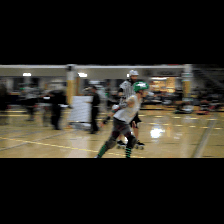

In [27]:
to_gif(sample_video)

除了查看此视频外，您还可以显示 UCF-101 数据。为此，请运行以下代码：

In [ ]:
# docs-infra: no-execute
ucf_sample_video = frames_from_video_file(next(subset_paths['train'].glob('*/*.avi')), 50)
to_gif(ucf_sample_video)

接下来，定义 `FrameGenerator` 类以创建一个可迭代对象，该对象可以将数据输入 TensorFlow 数据流水线。生成器 (`__call__`) 函数产生由 `frames_from_video_file` 生成的帧数组以及与帧集相关联的标签的独热编码向量。

In [28]:
class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

在将 `FrameGenerator` 对象封装为 TensorFlow Dataset 对象之前对其进行测试。此外，对于训练数据集，请确保启用训练模式，以便对数据进行重排。

In [29]:
fg = FrameGenerator(subset_paths['train'], 10, training=True)

frames, label = next(fg())

print(f"Shape: {frames.shape}")
print(f"Label: {label}")

Shape: (10, 224, 224, 3)
Label: 3


最后，创建一个 TensorFlow 数据输入流水线。您从生成器对象创建的此流水线允许您将数据输入深度学习模型。在此视频流水线中，每个元素都是一组单独的帧及其关联标签。 

In [30]:
# Create the training set
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))
train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], 10, training=True),
                                          output_signature = output_signature)

检查标签是否重排。 

In [31]:
for frames, labels in train_ds.take(10):
  print(labels)

tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(1, shape=(), dtype=int16)
tf.Tensor(9, shape=(), dtype=int16)


tf.Tensor(9, shape=(), dtype=int16)
tf.Tensor(0, shape=(), dtype=int16)


tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(5, shape=(), dtype=int16)


tf.Tensor(4, shape=(), dtype=int16)
tf.Tensor(9, shape=(), dtype=int16)
tf.Tensor(2, shape=(), dtype=int16)


In [32]:
# Create the validation set
val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], 10),
                                        output_signature = output_signature)

In [33]:
# Print the shapes of the data
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (10, 224, 224, 3)
Shape of training labels: ()


Shape of validation set of frames: (10, 224, 224, 3)
Shape of validation labels: ()


## 配置数据集以提高性能

使用缓冲预提取，以便从磁盘产生数据，而不会阻塞 I/O。下面是可以在加载数据时使用的两个重要函数：

- `Dataset.cache`：在第一个周期期间从磁盘加载图像后，它会将这些图像保留在内存中。该函数确保在训练模型时数据集不会成为瓶颈。如果数据集太大无法装入内存，您也可以使用此方法创建高性能的磁盘缓存。

- `Dataset.prefetch`：在训练时重叠数据预处理和模型执行。有关详细信息，请参阅[使用 `tf.data` 提升性能](https://tensorflow.google.cn/guide/data_performance)。

In [34]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

要准备馈送到模型的数据，请使用批处理，如下所示。请注意，在处理视频数据（例如 AVI 文件）时，数据应形成五维对象。这些维度如下：`[batch_size, number_of_frames, height, width, channels]`。相比之下，图像将具有四个维度：`[batch_size, height, width, channels]`。下图说明了如何表示视频数据的形状。

![视频数据形状](https://tensorflow.google.cn/images/tutorials/video/video_data_shape.png)


In [35]:
train_ds = train_ds.batch(2)
val_ds = val_ds.batch(2)

train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (2, 10, 224, 224, 3)
Shape of training labels: (2,)


Shape of validation set of frames: (2, 10, 224, 224, 3)
Shape of validation labels: (2,)


## 后续步骤

现在，您已经创建了带有标签的视频帧的 TensorFlow `Dataset`，您可以将其与深度学习模型一起使用。以下使用预训练的 [EfficientNet](https://arxiv.org/abs/1905.11946){:.external} 的分类模型可在几分钟内训练到较高准确率：

In [36]:
net = tf.keras.applications.EfficientNetB0(include_top = False)
net.trainable = False

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=255),
    tf.keras.layers.TimeDistributed(net),
    tf.keras.layers.Dense(10),
    tf.keras.layers.GlobalAveragePooling3D()
])

model.compile(optimizer = 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

model.fit(train_ds, 
          epochs = 10,
          validation_data = val_ds,
          callbacks = tf.keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss'))

    8192/16705208 [..............................] - ETA: 0s

 5480448/16705208 [========>.....................] - ETA: 0s

16705208/16705208 [==============================] - 0s 0us/step


Epoch 1/10


2023-11-07 23:39:10.086724: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/time_distributed/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


      1/Unknown - 11s 11s/step - loss: 2.5740 - accuracy: 0.0000e+00

      2/Unknown - 11s 53ms/step - loss: 2.5284 - accuracy: 0.0000e+00

I0000 00:00:1699400352.000239  555168 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


      3/Unknown - 12s 52ms/step - loss: 2.3643 - accuracy: 0.1667    

      4/Unknown - 12s 51ms/step - loss: 2.3322 - accuracy: 0.1250

      5/Unknown - 12s 51ms/step - loss: 2.3414 - accuracy: 0.2000

      6/Unknown - 12s 51ms/step - loss: 2.3178 - accuracy: 0.1667

      7/Unknown - 12s 51ms/step - loss: 2.2400 - accuracy: 0.2143

      9/Unknown - 12s 49ms/step - loss: 2.3296 - accuracy: 0.1667

     11/Unknown - 12s 47ms/step - loss: 2.3215 - accuracy: 0.1818

     13/Unknown - 12s 45ms/step - loss: 2.2755 - accuracy: 0.1538

     15/Unknown - 12s 44ms/step - loss: 2.3007 - accuracy: 0.1333

     17/Unknown - 12s 43ms/step - loss: 2.2216 - accuracy: 0.2353

     19/Unknown - 12s 43ms/step - loss: 2.1702 - accuracy: 0.2632

     21/Unknown - 12s 42ms/step - loss: 2.1293 - accuracy: 0.3095

     23/Unknown - 12s 42ms/step - loss: 2.1142 - accuracy: 0.3261

     25/Unknown - 12s 42ms/step - loss: 2.0910 - accuracy: 0.3400

     27/Unknown - 13s 41ms/step - loss: 2.0807 - accuracy: 0.3148

     29/Unknown - 13s 41ms/step - loss: 2.0191 - accuracy: 0.3621

     31/Unknown - 13s 41ms/step - loss: 1.9720 - accuracy: 0.3871

     33/Unknown - 13s 41ms/step - loss: 1.9815 - accuracy: 0.3788

     35/Unknown - 13s 41ms/step - loss: 1.9664 - accuracy: 0.3714

     37/Unknown - 13s 40ms/step - loss: 1.9182 - accuracy: 0.3919

     39/Unknown - 13s 40ms/step - loss: 1.9102 - accuracy: 0.3846

     41/Unknown - 13s 40ms/step - loss: 1.8868 - accuracy: 0.4024

     43/Unknown - 13s 40ms/step - loss: 1.8677 - accuracy: 0.4186

     45/Unknown - 13s 40ms/step - loss: 1.8436 - accuracy: 0.4333

     47/Unknown - 13s 40ms/step - loss: 1.8252 - accuracy: 0.4574

     49/Unknown - 13s 40ms/step - loss: 1.8053 - accuracy: 0.4694

     51/Unknown - 13s 40ms/step - loss: 1.7899 - accuracy: 0.4706

     53/Unknown - 14s 40ms/step - loss: 1.7864 - accuracy: 0.4717

     55/Unknown - 14s 40ms/step - loss: 1.7814 - accuracy: 0.4727

     57/Unknown - 14s 40ms/step - loss: 1.7691 - accuracy: 0.4825

     59/Unknown - 14s 40ms/step - loss: 1.7440 - accuracy: 0.5000

     61/Unknown - 14s 40ms/step - loss: 1.7258 - accuracy: 0.5082

     63/Unknown - 14s 40ms/step - loss: 1.6940 - accuracy: 0.5238

     65/Unknown - 14s 40ms/step - loss: 1.6647 - accuracy: 0.5385

     67/Unknown - 14s 40ms/step - loss: 1.6412 - accuracy: 0.5522

     69/Unknown - 14s 40ms/step - loss: 1.6216 - accuracy: 0.5652

     71/Unknown - 14s 39ms/step - loss: 1.6102 - accuracy: 0.5634

     73/Unknown - 14s 39ms/step - loss: 1.5878 - accuracy: 0.5753

     75/Unknown - 14s 39ms/step - loss: 1.5761 - accuracy: 0.5800

     77/Unknown - 14s 39ms/step - loss: 1.5631 - accuracy: 0.5844

     79/Unknown - 15s 39ms/step - loss: 1.5436 - accuracy: 0.5949

     81/Unknown - 15s 39ms/step - loss: 1.5281 - accuracy: 0.6049

     83/Unknown - 15s 39ms/step - loss: 1.5085 - accuracy: 0.6145

     85/Unknown - 15s 39ms/step - loss: 1.4928 - accuracy: 0.6235

     87/Unknown - 15s 39ms/step - loss: 1.4845 - accuracy: 0.6207

     89/Unknown - 15s 39ms/step - loss: 1.4795 - accuracy: 0.6236

     91/Unknown - 15s 39ms/step - loss: 1.4659 - accuracy: 0.6264

     93/Unknown - 15s 39ms/step - loss: 1.4562 - accuracy: 0.6290

     95/Unknown - 15s 39ms/step - loss: 1.4380 - accuracy: 0.6368

     97/Unknown - 15s 39ms/step - loss: 1.4274 - accuracy: 0.6392

     99/Unknown - 15s 39ms/step - loss: 1.4110 - accuracy: 0.6465

    101/Unknown - 15s 39ms/step - loss: 1.3947 - accuracy: 0.6485

    103/Unknown - 15s 39ms/step - loss: 1.3825 - accuracy: 0.6553

    105/Unknown - 16s 39ms/step - loss: 1.3660 - accuracy: 0.6619

    107/Unknown - 16s 39ms/step - loss: 1.3531 - accuracy: 0.6636

    109/Unknown - 16s 39ms/step - loss: 1.3460 - accuracy: 0.6651

    111/Unknown - 16s 39ms/step - loss: 1.3284 - accuracy: 0.6712

    113/Unknown - 16s 39ms/step - loss: 1.3188 - accuracy: 0.6726

    115/Unknown - 16s 39ms/step - loss: 1.3019 - accuracy: 0.6783

    117/Unknown - 16s 39ms/step - loss: 1.2920 - accuracy: 0.6838

    119/Unknown - 16s 39ms/step - loss: 1.2779 - accuracy: 0.6891

    121/Unknown - 16s 39ms/step - loss: 1.2704 - accuracy: 0.6860

    123/Unknown - 16s 39ms/step - loss: 1.2560 - accuracy: 0.6911

    125/Unknown - 16s 39ms/step - loss: 1.2415 - accuracy: 0.6960

    127/Unknown - 16s 39ms/step - loss: 1.2312 - accuracy: 0.7008

    129/Unknown - 16s 39ms/step - loss: 1.2233 - accuracy: 0.7016

    131/Unknown - 17s 39ms/step - loss: 1.2125 - accuracy: 0.7061

    133/Unknown - 17s 39ms/step - loss: 1.2011 - accuracy: 0.7105

    135/Unknown - 17s 39ms/step - loss: 1.1909 - accuracy: 0.7148

    137/Unknown - 17s 39ms/step - loss: 1.1826 - accuracy: 0.7190

    139/Unknown - 17s 39ms/step - loss: 1.1737 - accuracy: 0.7230

    141/Unknown - 17s 39ms/step - loss: 1.1639 - accuracy: 0.7270

    143/Unknown - 17s 39ms/step - loss: 1.1576 - accuracy: 0.7308

    145/Unknown - 17s 39ms/step - loss: 1.1509 - accuracy: 0.7345

    147/Unknown - 17s 39ms/step - loss: 1.1424 - accuracy: 0.7381

    149/Unknown - 17s 39ms/step - loss: 1.1353 - accuracy: 0.7416

150/150 [==============================] - 23s 80ms/step - loss: 1.1324 - accuracy: 0.7433 - val_loss: 0.5808 - val_accuracy: 0.8200


Epoch 2/10


  1/150 [..............................] - ETA: 6s - loss: 0.4550 - accuracy: 1.0000

  3/150 [..............................] - ETA: 5s - loss: 0.3261 - accuracy: 1.0000

  5/150 [>.............................] - ETA: 5s - loss: 0.2783 - accuracy: 1.0000

  7/150 [>.............................] - ETA: 5s - loss: 0.2511 - accuracy: 1.0000

  9/150 [>.............................] - ETA: 5s - loss: 0.2691 - accuracy: 0.9444

 11/150 [=>............................] - ETA: 5s - loss: 0.3477 - accuracy: 0.9091

 13/150 [=>............................] - ETA: 5s - loss: 0.3500 - accuracy: 0.8846

 15/150 [==>...........................] - ETA: 5s - loss: 0.3807 - accuracy: 0.8667

 17/150 [==>...........................] - ETA: 5s - loss: 0.4394 - accuracy: 0.8824

 19/150 [==>...........................] - ETA: 5s - loss: 0.4317 - accuracy: 0.8947

 21/150 [===>..........................] - ETA: 4s - loss: 0.4269 - accuracy: 0.9048

 23/150 [===>..........................] - ETA: 4s - loss: 0.4365 - accuracy: 0.9130

 25/150 [====>.........................] - ETA: 4s - loss: 0.4172 - accuracy: 0.9200

 27/150 [====>.........................] - ETA: 4s - loss: 0.3962 - accuracy: 0.9259

 29/150 [====>.........................] - ETA: 4s - loss: 0.3954 - accuracy: 0.9310

 31/150 [=====>........................] - ETA: 4s - loss: 0.3917 - accuracy: 0.9355

 33/150 [=====>........................] - ETA: 4s - loss: 0.4005 - accuracy: 0.9242

 35/150 [======>.......................] - ETA: 4s - loss: 0.4017 - accuracy: 0.9286

 37/150 [======>.......................] - ETA: 4s - loss: 0.4020 - accuracy: 0.9324

 39/150 [======>.......................] - ETA: 4s - loss: 0.4055 - accuracy: 0.9359

 41/150 [=======>......................] - ETA: 4s - loss: 0.3979 - accuracy: 0.9390

 43/150 [=======>......................] - ETA: 4s - loss: 0.4028 - accuracy: 0.9419

 45/150 [========>.....................] - ETA: 4s - loss: 0.4072 - accuracy: 0.9444

 47/150 [========>.....................] - ETA: 3s - loss: 0.4046 - accuracy: 0.9468

 49/150 [========>.....................] - ETA: 3s - loss: 0.3920 - accuracy: 0.9490

 51/150 [=========>....................] - ETA: 3s - loss: 0.4020 - accuracy: 0.9412

 53/150 [=========>....................] - ETA: 3s - loss: 0.3937 - accuracy: 0.9434

 55/150 [==========>...................] - ETA: 3s - loss: 0.3952 - accuracy: 0.9455

 57/150 [==========>...................] - ETA: 3s - loss: 0.3956 - accuracy: 0.9474

 59/150 [==========>...................] - ETA: 3s - loss: 0.4020 - accuracy: 0.9492

 61/150 [===========>..................] - ETA: 3s - loss: 0.3995 - accuracy: 0.9508

 63/150 [===========>..................] - ETA: 3s - loss: 0.4105 - accuracy: 0.9444

 65/150 [============>.................] - ETA: 3s - loss: 0.4095 - accuracy: 0.9462

 67/150 [============>.................] - ETA: 3s - loss: 0.4004 - accuracy: 0.9478

 69/150 [============>.................] - ETA: 3s - loss: 0.3976 - accuracy: 0.9493

 71/150 [=============>................] - ETA: 3s - loss: 0.4087 - accuracy: 0.9437

 73/150 [=============>................] - ETA: 2s - loss: 0.4031 - accuracy: 0.9452

 75/150 [==============>...............] - ETA: 2s - loss: 0.4006 - accuracy: 0.9467

 77/150 [==============>...............] - ETA: 2s - loss: 0.4079 - accuracy: 0.9481

 79/150 [==============>...............] - ETA: 2s - loss: 0.4042 - accuracy: 0.9494

 81/150 [===============>..............] - ETA: 2s - loss: 0.3974 - accuracy: 0.9506

 83/150 [===============>..............] - ETA: 2s - loss: 0.3939 - accuracy: 0.9518

 85/150 [================>.............] - ETA: 2s - loss: 0.3930 - accuracy: 0.9529

 87/150 [================>.............] - ETA: 2s - loss: 0.3923 - accuracy: 0.9540

 89/150 [================>.............] - ETA: 2s - loss: 0.3887 - accuracy: 0.9551

 91/150 [=================>............] - ETA: 2s - loss: 0.3902 - accuracy: 0.9560

 93/150 [=================>............] - ETA: 2s - loss: 0.3924 - accuracy: 0.9570

 95/150 [==================>...........] - ETA: 2s - loss: 0.3934 - accuracy: 0.9579

 97/150 [==================>...........] - ETA: 2s - loss: 0.3934 - accuracy: 0.9588

 99/150 [==================>...........] - ETA: 1s - loss: 0.3875 - accuracy: 0.9596

101/150 [===================>..........] - ETA: 1s - loss: 0.3831 - accuracy: 0.9604

103/150 [===================>..........] - ETA: 1s - loss: 0.3789 - accuracy: 0.9612

105/150 [====================>.........] - ETA: 1s - loss: 0.3751 - accuracy: 0.9619

107/150 [====================>.........] - ETA: 1s - loss: 0.3717 - accuracy: 0.9626

109/150 [====================>.........] - ETA: 1s - loss: 0.3667 - accuracy: 0.9633

111/150 [=====================>........] - ETA: 1s - loss: 0.3617 - accuracy: 0.9640

113/150 [=====================>........] - ETA: 1s - loss: 0.3585 - accuracy: 0.9646

115/150 [======================>.......] - ETA: 1s - loss: 0.3566 - accuracy: 0.9652

117/150 [======================>.......] - ETA: 1s - loss: 0.3533 - accuracy: 0.9658

119/150 [======================>.......] - ETA: 1s - loss: 0.3566 - accuracy: 0.9622

121/150 [=======================>......] - ETA: 1s - loss: 0.3533 - accuracy: 0.9628

123/150 [=======================>......] - ETA: 1s - loss: 0.3494 - accuracy: 0.9634

125/150 [========================>.....] - ETA: 0s - loss: 0.3460 - accuracy: 0.9640

127/150 [========================>.....] - ETA: 0s - loss: 0.3441 - accuracy: 0.9646

129/150 [========================>.....] - ETA: 0s - loss: 0.3428 - accuracy: 0.9651

131/150 [=========================>....] - ETA: 0s - loss: 0.3382 - accuracy: 0.9656

133/150 [=========================>....] - ETA: 0s - loss: 0.3525 - accuracy: 0.9624

135/150 [==========================>...] - ETA: 0s - loss: 0.3508 - accuracy: 0.9630

137/150 [==========================>...] - ETA: 0s - loss: 0.3493 - accuracy: 0.9635

139/150 [==========================>...] - ETA: 0s - loss: 0.3491 - accuracy: 0.9640

141/150 [===========================>..] - ETA: 0s - loss: 0.3462 - accuracy: 0.9645

143/150 [===========================>..] - ETA: 0s - loss: 0.3495 - accuracy: 0.9615

145/150 [============================>.] - ETA: 0s - loss: 0.3476 - accuracy: 0.9621

147/150 [============================>.] - ETA: 0s - loss: 0.3439 - accuracy: 0.9626

149/150 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.9631

150/150 [==============================] - 8s 51ms/step - loss: 0.3391 - accuracy: 0.9633 - val_loss: 0.3407 - val_accuracy: 0.9300


Epoch 3/10


  1/150 [..............................] - ETA: 6s - loss: 0.0556 - accuracy: 1.0000

  3/150 [..............................] - ETA: 5s - loss: 0.2627 - accuracy: 1.0000

  5/150 [>.............................] - ETA: 5s - loss: 0.2339 - accuracy: 1.0000

  7/150 [>.............................] - ETA: 5s - loss: 0.2172 - accuracy: 1.0000

  9/150 [>.............................] - ETA: 5s - loss: 0.1864 - accuracy: 1.0000

 11/150 [=>............................] - ETA: 5s - loss: 0.1897 - accuracy: 1.0000

 13/150 [=>............................] - ETA: 5s - loss: 0.1933 - accuracy: 1.0000

 15/150 [==>...........................] - ETA: 5s - loss: 0.2020 - accuracy: 1.0000

 17/150 [==>...........................] - ETA: 5s - loss: 0.2068 - accuracy: 1.0000

 19/150 [==>...........................] - ETA: 5s - loss: 0.2280 - accuracy: 1.0000

 21/150 [===>..........................] - ETA: 4s - loss: 0.2157 - accuracy: 1.0000

 23/150 [===>..........................] - ETA: 4s - loss: 0.2029 - accuracy: 1.0000

 25/150 [====>.........................] - ETA: 4s - loss: 0.2050 - accuracy: 1.0000

 27/150 [====>.........................] - ETA: 4s - loss: 0.1967 - accuracy: 1.0000

 29/150 [====>.........................] - ETA: 4s - loss: 0.1937 - accuracy: 1.0000

 31/150 [=====>........................] - ETA: 4s - loss: 0.1869 - accuracy: 1.0000

 33/150 [=====>........................] - ETA: 4s - loss: 0.1803 - accuracy: 1.0000

 35/150 [======>.......................] - ETA: 4s - loss: 0.1840 - accuracy: 1.0000

 37/150 [======>.......................] - ETA: 4s - loss: 0.1801 - accuracy: 1.0000

 39/150 [======>.......................] - ETA: 4s - loss: 0.1761 - accuracy: 1.0000

 41/150 [=======>......................] - ETA: 4s - loss: 0.1854 - accuracy: 1.0000

 43/150 [=======>......................] - ETA: 4s - loss: 0.1911 - accuracy: 0.9884

 45/150 [========>.....................] - ETA: 4s - loss: 0.1952 - accuracy: 0.9889

 47/150 [========>.....................] - ETA: 3s - loss: 0.1900 - accuracy: 0.9894

 49/150 [========>.....................] - ETA: 3s - loss: 0.1906 - accuracy: 0.9898

 51/150 [=========>....................] - ETA: 3s - loss: 0.1921 - accuracy: 0.9902

 53/150 [=========>....................] - ETA: 3s - loss: 0.1964 - accuracy: 0.9906

 55/150 [==========>...................] - ETA: 3s - loss: 0.1988 - accuracy: 0.9909

 57/150 [==========>...................] - ETA: 3s - loss: 0.2053 - accuracy: 0.9912

 59/150 [==========>...................] - ETA: 3s - loss: 0.2019 - accuracy: 0.9915

 61/150 [===========>..................] - ETA: 3s - loss: 0.2006 - accuracy: 0.9918

 63/150 [===========>..................] - ETA: 3s - loss: 0.1993 - accuracy: 0.9921

 65/150 [============>.................] - ETA: 3s - loss: 0.1980 - accuracy: 0.9923

 67/150 [============>.................] - ETA: 3s - loss: 0.2092 - accuracy: 0.9851

 69/150 [============>.................] - ETA: 3s - loss: 0.2070 - accuracy: 0.9855

 71/150 [=============>................] - ETA: 3s - loss: 0.2051 - accuracy: 0.9859

 73/150 [=============>................] - ETA: 2s - loss: 0.2010 - accuracy: 0.9863

 75/150 [==============>...............] - ETA: 2s - loss: 0.1982 - accuracy: 0.9867

 77/150 [==============>...............] - ETA: 2s - loss: 0.1955 - accuracy: 0.9870

 79/150 [==============>...............] - ETA: 2s - loss: 0.2031 - accuracy: 0.9873

 81/150 [===============>..............] - ETA: 2s - loss: 0.2011 - accuracy: 0.9877

 83/150 [===============>..............] - ETA: 2s - loss: 0.1981 - accuracy: 0.9880

 85/150 [================>.............] - ETA: 2s - loss: 0.1960 - accuracy: 0.9882

 87/150 [================>.............] - ETA: 2s - loss: 0.1965 - accuracy: 0.9885

 89/150 [================>.............] - ETA: 2s - loss: 0.1937 - accuracy: 0.9888

 91/150 [=================>............] - ETA: 2s - loss: 0.1914 - accuracy: 0.9890

 93/150 [=================>............] - ETA: 2s - loss: 0.1892 - accuracy: 0.9892

 95/150 [==================>...........] - ETA: 2s - loss: 0.1926 - accuracy: 0.9895

 97/150 [==================>...........] - ETA: 2s - loss: 0.1915 - accuracy: 0.9897

 99/150 [==================>...........] - ETA: 1s - loss: 0.1884 - accuracy: 0.9899

101/150 [===================>..........] - ETA: 1s - loss: 0.1867 - accuracy: 0.9901

103/150 [===================>..........] - ETA: 1s - loss: 0.1859 - accuracy: 0.9903

105/150 [====================>.........] - ETA: 1s - loss: 0.1842 - accuracy: 0.9905

107/150 [====================>.........] - ETA: 1s - loss: 0.1817 - accuracy: 0.9907

109/150 [====================>.........] - ETA: 1s - loss: 0.1834 - accuracy: 0.9908

111/150 [=====================>........] - ETA: 1s - loss: 0.1819 - accuracy: 0.9910

113/150 [=====================>........] - ETA: 1s - loss: 0.1800 - accuracy: 0.9912

115/150 [======================>.......] - ETA: 1s - loss: 0.1784 - accuracy: 0.9913

117/150 [======================>.......] - ETA: 1s - loss: 0.1770 - accuracy: 0.9915

119/150 [======================>.......] - ETA: 1s - loss: 0.1782 - accuracy: 0.9916

121/150 [=======================>......] - ETA: 1s - loss: 0.1823 - accuracy: 0.9917

123/150 [=======================>......] - ETA: 1s - loss: 0.1812 - accuracy: 0.9919

125/150 [========================>.....] - ETA: 0s - loss: 0.1792 - accuracy: 0.9920

127/150 [========================>.....] - ETA: 0s - loss: 0.1766 - accuracy: 0.9921

129/150 [========================>.....] - ETA: 0s - loss: 0.1814 - accuracy: 0.9922

131/150 [=========================>....] - ETA: 0s - loss: 0.1811 - accuracy: 0.9924

133/150 [=========================>....] - ETA: 0s - loss: 0.1807 - accuracy: 0.9925

135/150 [==========================>...] - ETA: 0s - loss: 0.1812 - accuracy: 0.9926

137/150 [==========================>...] - ETA: 0s - loss: 0.1808 - accuracy: 0.9927

139/150 [==========================>...] - ETA: 0s - loss: 0.1827 - accuracy: 0.9928

141/150 [===========================>..] - ETA: 0s - loss: 0.1870 - accuracy: 0.9894

143/150 [===========================>..] - ETA: 0s - loss: 0.1873 - accuracy: 0.9895

145/150 [============================>.] - ETA: 0s - loss: 0.1865 - accuracy: 0.9897

147/150 [============================>.] - ETA: 0s - loss: 0.1847 - accuracy: 0.9898

149/150 [============================>.] - ETA: 0s - loss: 0.1830 - accuracy: 0.9899

150/150 [==============================] - 8s 51ms/step - loss: 0.1864 - accuracy: 0.9900 - val_loss: 0.2591 - val_accuracy: 0.9500


Epoch 4/10


  1/150 [..............................] - ETA: 6s - loss: 0.1205 - accuracy: 1.0000

  3/150 [..............................] - ETA: 5s - loss: 0.1329 - accuracy: 1.0000

  5/150 [>.............................] - ETA: 5s - loss: 0.1008 - accuracy: 1.0000

  7/150 [>.............................] - ETA: 5s - loss: 0.1419 - accuracy: 1.0000

  9/150 [>.............................] - ETA: 5s - loss: 0.1239 - accuracy: 1.0000

 11/150 [=>............................] - ETA: 5s - loss: 0.1168 - accuracy: 1.0000

 13/150 [=>............................] - ETA: 5s - loss: 0.1139 - accuracy: 1.0000

 15/150 [==>...........................] - ETA: 5s - loss: 0.1130 - accuracy: 1.0000

 17/150 [==>...........................] - ETA: 5s - loss: 0.1171 - accuracy: 1.0000

 19/150 [==>...........................] - ETA: 5s - loss: 0.1234 - accuracy: 1.0000

 21/150 [===>..........................] - ETA: 5s - loss: 0.1173 - accuracy: 1.0000

 23/150 [===>..........................] - ETA: 4s - loss: 0.1146 - accuracy: 1.0000

 25/150 [====>.........................] - ETA: 4s - loss: 0.1157 - accuracy: 1.0000

 27/150 [====>.........................] - ETA: 4s - loss: 0.1202 - accuracy: 1.0000

 29/150 [====>.........................] - ETA: 4s - loss: 0.1252 - accuracy: 1.0000

 31/150 [=====>........................] - ETA: 4s - loss: 0.1217 - accuracy: 1.0000

 33/150 [=====>........................] - ETA: 4s - loss: 0.1212 - accuracy: 1.0000

 35/150 [======>.......................] - ETA: 4s - loss: 0.1167 - accuracy: 1.0000

 37/150 [======>.......................] - ETA: 4s - loss: 0.1187 - accuracy: 1.0000

 39/150 [======>.......................] - ETA: 4s - loss: 0.1166 - accuracy: 1.0000

 41/150 [=======>......................] - ETA: 4s - loss: 0.1150 - accuracy: 1.0000

 43/150 [=======>......................] - ETA: 4s - loss: 0.1147 - accuracy: 1.0000

 45/150 [========>.....................] - ETA: 4s - loss: 0.1149 - accuracy: 1.0000

 47/150 [========>.....................] - ETA: 3s - loss: 0.1129 - accuracy: 1.0000

 49/150 [========>.....................] - ETA: 3s - loss: 0.1100 - accuracy: 1.0000

 51/150 [=========>....................] - ETA: 3s - loss: 0.1071 - accuracy: 1.0000

 53/150 [=========>....................] - ETA: 3s - loss: 0.1065 - accuracy: 1.0000

 55/150 [==========>...................] - ETA: 3s - loss: 0.1073 - accuracy: 1.0000

 57/150 [==========>...................] - ETA: 3s - loss: 0.1042 - accuracy: 1.0000

 59/150 [==========>...................] - ETA: 3s - loss: 0.1037 - accuracy: 1.0000

 61/150 [===========>..................] - ETA: 3s - loss: 0.1150 - accuracy: 0.9918

 63/150 [===========>..................] - ETA: 3s - loss: 0.1152 - accuracy: 0.9921

 65/150 [============>.................] - ETA: 3s - loss: 0.1153 - accuracy: 0.9923

 67/150 [============>.................] - ETA: 3s - loss: 0.1142 - accuracy: 0.9925

 69/150 [============>.................] - ETA: 3s - loss: 0.1145 - accuracy: 0.9928

 71/150 [=============>................] - ETA: 3s - loss: 0.1135 - accuracy: 0.9930

 73/150 [=============>................] - ETA: 2s - loss: 0.1138 - accuracy: 0.9932

 75/150 [==============>...............] - ETA: 2s - loss: 0.1136 - accuracy: 0.9933

 77/150 [==============>...............] - ETA: 2s - loss: 0.1193 - accuracy: 0.9935

 79/150 [==============>...............] - ETA: 2s - loss: 0.1226 - accuracy: 0.9937

 81/150 [===============>..............] - ETA: 2s - loss: 0.1206 - accuracy: 0.9938

 83/150 [===============>..............] - ETA: 2s - loss: 0.1214 - accuracy: 0.9940

 85/150 [================>.............] - ETA: 2s - loss: 0.1195 - accuracy: 0.9941

 87/150 [================>.............] - ETA: 2s - loss: 0.1186 - accuracy: 0.9943

 89/150 [================>.............] - ETA: 2s - loss: 0.1179 - accuracy: 0.9944

 91/150 [=================>............] - ETA: 2s - loss: 0.1162 - accuracy: 0.9945

 93/150 [=================>............] - ETA: 2s - loss: 0.1149 - accuracy: 0.9946

 95/150 [==================>...........] - ETA: 2s - loss: 0.1134 - accuracy: 0.9947

 97/150 [==================>...........] - ETA: 2s - loss: 0.1133 - accuracy: 0.9948

 99/150 [==================>...........] - ETA: 1s - loss: 0.1126 - accuracy: 0.9949

101/150 [===================>..........] - ETA: 1s - loss: 0.1190 - accuracy: 0.9950

103/150 [===================>..........] - ETA: 1s - loss: 0.1189 - accuracy: 0.9951

105/150 [====================>.........] - ETA: 1s - loss: 0.1201 - accuracy: 0.9952

107/150 [====================>.........] - ETA: 1s - loss: 0.1189 - accuracy: 0.9953

109/150 [====================>.........] - ETA: 1s - loss: 0.1182 - accuracy: 0.9954

111/150 [=====================>........] - ETA: 1s - loss: 0.1168 - accuracy: 0.9955

113/150 [=====================>........] - ETA: 1s - loss: 0.1184 - accuracy: 0.9956

115/150 [======================>.......] - ETA: 1s - loss: 0.1181 - accuracy: 0.9957

117/150 [======================>.......] - ETA: 1s - loss: 0.1249 - accuracy: 0.9915

119/150 [======================>.......] - ETA: 1s - loss: 0.1257 - accuracy: 0.9916

121/150 [=======================>......] - ETA: 1s - loss: 0.1276 - accuracy: 0.9917

123/150 [=======================>......] - ETA: 1s - loss: 0.1261 - accuracy: 0.9919

125/150 [========================>.....] - ETA: 0s - loss: 0.1245 - accuracy: 0.9920

127/150 [========================>.....] - ETA: 0s - loss: 0.1242 - accuracy: 0.9921

129/150 [========================>.....] - ETA: 0s - loss: 0.1226 - accuracy: 0.9922

131/150 [=========================>....] - ETA: 0s - loss: 0.1228 - accuracy: 0.9924

133/150 [=========================>....] - ETA: 0s - loss: 0.1226 - accuracy: 0.9925

135/150 [==========================>...] - ETA: 0s - loss: 0.1212 - accuracy: 0.9926

137/150 [==========================>...] - ETA: 0s - loss: 0.1239 - accuracy: 0.9927

139/150 [==========================>...] - ETA: 0s - loss: 0.1252 - accuracy: 0.9928

141/150 [===========================>..] - ETA: 0s - loss: 0.1242 - accuracy: 0.9929

143/150 [===========================>..] - ETA: 0s - loss: 0.1235 - accuracy: 0.9930

145/150 [============================>.] - ETA: 0s - loss: 0.1229 - accuracy: 0.9931

147/150 [============================>.] - ETA: 0s - loss: 0.1216 - accuracy: 0.9932

149/150 [============================>.] - ETA: 0s - loss: 0.1211 - accuracy: 0.9933

150/150 [==============================] - 8s 51ms/step - loss: 0.1216 - accuracy: 0.9933 - val_loss: 0.2290 - val_accuracy: 0.9300


Epoch 5/10


  1/150 [..............................] - ETA: 6s - loss: 0.1072 - accuracy: 1.0000

  3/150 [..............................] - ETA: 5s - loss: 0.0846 - accuracy: 1.0000

  5/150 [>.............................] - ETA: 5s - loss: 0.0697 - accuracy: 1.0000

  7/150 [>.............................] - ETA: 5s - loss: 0.0653 - accuracy: 1.0000

  9/150 [>.............................] - ETA: 5s - loss: 0.0561 - accuracy: 1.0000

 11/150 [=>............................] - ETA: 5s - loss: 0.0596 - accuracy: 1.0000

 13/150 [=>............................] - ETA: 5s - loss: 0.0585 - accuracy: 1.0000

 15/150 [==>...........................] - ETA: 5s - loss: 0.0528 - accuracy: 1.0000

 17/150 [==>...........................] - ETA: 5s - loss: 0.0638 - accuracy: 1.0000

 19/150 [==>...........................] - ETA: 5s - loss: 0.0605 - accuracy: 1.0000

 21/150 [===>..........................] - ETA: 5s - loss: 0.0712 - accuracy: 1.0000

 23/150 [===>..........................] - ETA: 4s - loss: 0.0697 - accuracy: 1.0000

 25/150 [====>.........................] - ETA: 4s - loss: 0.0665 - accuracy: 1.0000

 27/150 [====>.........................] - ETA: 4s - loss: 0.0662 - accuracy: 1.0000

 29/150 [====>.........................] - ETA: 4s - loss: 0.0657 - accuracy: 1.0000

 31/150 [=====>........................] - ETA: 4s - loss: 0.0670 - accuracy: 1.0000

 33/150 [=====>........................] - ETA: 4s - loss: 0.0647 - accuracy: 1.0000

 35/150 [======>.......................] - ETA: 4s - loss: 0.0641 - accuracy: 1.0000

 37/150 [======>.......................] - ETA: 4s - loss: 0.0633 - accuracy: 1.0000

 39/150 [======>.......................] - ETA: 4s - loss: 0.0645 - accuracy: 1.0000

 41/150 [=======>......................] - ETA: 4s - loss: 0.0629 - accuracy: 1.0000

 43/150 [=======>......................] - ETA: 4s - loss: 0.0610 - accuracy: 1.0000

 45/150 [========>.....................] - ETA: 4s - loss: 0.0596 - accuracy: 1.0000

 47/150 [========>.....................] - ETA: 4s - loss: 0.0609 - accuracy: 1.0000

 49/150 [========>.....................] - ETA: 3s - loss: 0.0668 - accuracy: 1.0000

 51/150 [=========>....................] - ETA: 3s - loss: 0.0678 - accuracy: 1.0000

 53/150 [=========>....................] - ETA: 3s - loss: 0.0698 - accuracy: 1.0000

 55/150 [==========>...................] - ETA: 3s - loss: 0.0696 - accuracy: 1.0000

 57/150 [==========>...................] - ETA: 3s - loss: 0.0674 - accuracy: 1.0000

 59/150 [==========>...................] - ETA: 3s - loss: 0.0684 - accuracy: 1.0000

 61/150 [===========>..................] - ETA: 3s - loss: 0.0700 - accuracy: 1.0000

 63/150 [===========>..................] - ETA: 3s - loss: 0.0692 - accuracy: 1.0000

 65/150 [============>.................] - ETA: 3s - loss: 0.0685 - accuracy: 1.0000

 67/150 [============>.................] - ETA: 3s - loss: 0.0709 - accuracy: 1.0000

 69/150 [============>.................] - ETA: 3s - loss: 0.0726 - accuracy: 1.0000

 71/150 [=============>................] - ETA: 3s - loss: 0.0713 - accuracy: 1.0000

 73/150 [=============>................] - ETA: 3s - loss: 0.0757 - accuracy: 1.0000

 75/150 [==============>...............] - ETA: 2s - loss: 0.0740 - accuracy: 1.0000

 77/150 [==============>...............] - ETA: 2s - loss: 0.0730 - accuracy: 1.0000

 79/150 [==============>...............] - ETA: 2s - loss: 0.0749 - accuracy: 1.0000

 81/150 [===============>..............] - ETA: 2s - loss: 0.0755 - accuracy: 1.0000

 83/150 [===============>..............] - ETA: 2s - loss: 0.0755 - accuracy: 1.0000

 85/150 [================>.............] - ETA: 2s - loss: 0.0743 - accuracy: 1.0000

 87/150 [================>.............] - ETA: 2s - loss: 0.0739 - accuracy: 1.0000

 89/150 [================>.............] - ETA: 2s - loss: 0.0739 - accuracy: 1.0000

 91/150 [=================>............] - ETA: 2s - loss: 0.0731 - accuracy: 1.0000

 93/150 [=================>............] - ETA: 2s - loss: 0.0725 - accuracy: 1.0000

 95/150 [==================>...........] - ETA: 2s - loss: 0.0717 - accuracy: 1.0000

 97/150 [==================>...........] - ETA: 2s - loss: 0.0709 - accuracy: 1.0000

 99/150 [==================>...........] - ETA: 2s - loss: 0.0702 - accuracy: 1.0000

101/150 [===================>..........] - ETA: 1s - loss: 0.0707 - accuracy: 1.0000

103/150 [===================>..........] - ETA: 1s - loss: 0.0702 - accuracy: 1.0000

105/150 [====================>.........] - ETA: 1s - loss: 0.0739 - accuracy: 1.0000

107/150 [====================>.........] - ETA: 1s - loss: 0.0750 - accuracy: 1.0000

109/150 [====================>.........] - ETA: 1s - loss: 0.0759 - accuracy: 1.0000

111/150 [=====================>........] - ETA: 1s - loss: 0.0752 - accuracy: 1.0000

113/150 [=====================>........] - ETA: 1s - loss: 0.0765 - accuracy: 1.0000

115/150 [======================>.......] - ETA: 1s - loss: 0.0755 - accuracy: 1.0000

117/150 [======================>.......] - ETA: 1s - loss: 0.0744 - accuracy: 1.0000

119/150 [======================>.......] - ETA: 1s - loss: 0.0750 - accuracy: 1.0000

121/150 [=======================>......] - ETA: 1s - loss: 0.0752 - accuracy: 1.0000

123/150 [=======================>......] - ETA: 1s - loss: 0.0748 - accuracy: 1.0000

125/150 [========================>.....] - ETA: 0s - loss: 0.0792 - accuracy: 0.9960

127/150 [========================>.....] - ETA: 0s - loss: 0.0797 - accuracy: 0.9961

129/150 [========================>.....] - ETA: 0s - loss: 0.0816 - accuracy: 0.9961

131/150 [=========================>....] - ETA: 0s - loss: 0.0804 - accuracy: 0.9962

133/150 [=========================>....] - ETA: 0s - loss: 0.0800 - accuracy: 0.9962

135/150 [==========================>...] - ETA: 0s - loss: 0.0835 - accuracy: 0.9963

137/150 [==========================>...] - ETA: 0s - loss: 0.0847 - accuracy: 0.9964

139/150 [==========================>...] - ETA: 0s - loss: 0.0846 - accuracy: 0.9964

141/150 [===========================>..] - ETA: 0s - loss: 0.0843 - accuracy: 0.9965

143/150 [===========================>..] - ETA: 0s - loss: 0.0844 - accuracy: 0.9965

145/150 [============================>.] - ETA: 0s - loss: 0.0853 - accuracy: 0.9966

147/150 [============================>.] - ETA: 0s - loss: 0.0862 - accuracy: 0.9966

149/150 [============================>.] - ETA: 0s - loss: 0.0860 - accuracy: 0.9966

150/150 [==============================] - 8s 52ms/step - loss: 0.0864 - accuracy: 0.9967 - val_loss: 0.2058 - val_accuracy: 0.9300


Epoch 6/10


  1/150 [..............................] - ETA: 6s - loss: 0.0460 - accuracy: 1.0000

  3/150 [..............................] - ETA: 5s - loss: 0.0682 - accuracy: 1.0000

  5/150 [>.............................] - ETA: 5s - loss: 0.0565 - accuracy: 1.0000

  7/150 [>.............................] - ETA: 5s - loss: 0.0455 - accuracy: 1.0000

  9/150 [>.............................] - ETA: 5s - loss: 0.0418 - accuracy: 1.0000

 11/150 [=>............................] - ETA: 5s - loss: 0.0421 - accuracy: 1.0000

 13/150 [=>............................] - ETA: 5s - loss: 0.0388 - accuracy: 1.0000

 15/150 [==>...........................] - ETA: 5s - loss: 0.0461 - accuracy: 1.0000

 17/150 [==>...........................] - ETA: 5s - loss: 0.0508 - accuracy: 1.0000

 19/150 [==>...........................] - ETA: 5s - loss: 0.0542 - accuracy: 1.0000

 21/150 [===>..........................] - ETA: 4s - loss: 0.0567 - accuracy: 1.0000

 23/150 [===>..........................] - ETA: 4s - loss: 0.0546 - accuracy: 1.0000

 25/150 [====>.........................] - ETA: 4s - loss: 0.0595 - accuracy: 1.0000

 27/150 [====>.........................] - ETA: 4s - loss: 0.0596 - accuracy: 1.0000

 29/150 [====>.........................] - ETA: 4s - loss: 0.0600 - accuracy: 1.0000

 31/150 [=====>........................] - ETA: 4s - loss: 0.0598 - accuracy: 1.0000

 33/150 [=====>........................] - ETA: 4s - loss: 0.0580 - accuracy: 1.0000

 35/150 [======>.......................] - ETA: 4s - loss: 0.0598 - accuracy: 1.0000

 37/150 [======>.......................] - ETA: 4s - loss: 0.0663 - accuracy: 1.0000

 39/150 [======>.......................] - ETA: 4s - loss: 0.0683 - accuracy: 1.0000

 41/150 [=======>......................] - ETA: 4s - loss: 0.0770 - accuracy: 1.0000

 43/150 [=======>......................] - ETA: 4s - loss: 0.0817 - accuracy: 1.0000

 45/150 [========>.....................] - ETA: 4s - loss: 0.0799 - accuracy: 1.0000

 47/150 [========>.....................] - ETA: 4s - loss: 0.0783 - accuracy: 1.0000

 49/150 [========>.....................] - ETA: 3s - loss: 0.0780 - accuracy: 1.0000

 51/150 [=========>....................] - ETA: 3s - loss: 0.0769 - accuracy: 1.0000

 53/150 [=========>....................] - ETA: 3s - loss: 0.0753 - accuracy: 1.0000

 55/150 [==========>...................] - ETA: 3s - loss: 0.0768 - accuracy: 1.0000

 57/150 [==========>...................] - ETA: 3s - loss: 0.0756 - accuracy: 1.0000

 59/150 [==========>...................] - ETA: 3s - loss: 0.0747 - accuracy: 1.0000

 61/150 [===========>..................] - ETA: 3s - loss: 0.0733 - accuracy: 1.0000

 63/150 [===========>..................] - ETA: 3s - loss: 0.0733 - accuracy: 1.0000

 65/150 [============>.................] - ETA: 3s - loss: 0.0752 - accuracy: 1.0000

 67/150 [============>.................] - ETA: 3s - loss: 0.0737 - accuracy: 1.0000

 69/150 [============>.................] - ETA: 3s - loss: 0.0726 - accuracy: 1.0000

 71/150 [=============>................] - ETA: 3s - loss: 0.0716 - accuracy: 1.0000

 73/150 [=============>................] - ETA: 3s - loss: 0.0699 - accuracy: 1.0000

 75/150 [==============>...............] - ETA: 2s - loss: 0.0699 - accuracy: 1.0000

 77/150 [==============>...............] - ETA: 2s - loss: 0.0689 - accuracy: 1.0000

 79/150 [==============>...............] - ETA: 2s - loss: 0.0676 - accuracy: 1.0000

 81/150 [===============>..............] - ETA: 2s - loss: 0.0663 - accuracy: 1.0000

 83/150 [===============>..............] - ETA: 2s - loss: 0.0655 - accuracy: 1.0000

 85/150 [================>.............] - ETA: 2s - loss: 0.0650 - accuracy: 1.0000

 87/150 [================>.............] - ETA: 2s - loss: 0.0656 - accuracy: 1.0000

 89/150 [================>.............] - ETA: 2s - loss: 0.0673 - accuracy: 1.0000

 91/150 [=================>............] - ETA: 2s - loss: 0.0667 - accuracy: 1.0000

 93/150 [=================>............] - ETA: 2s - loss: 0.0660 - accuracy: 1.0000

 95/150 [==================>...........] - ETA: 2s - loss: 0.0653 - accuracy: 1.0000

 97/150 [==================>...........] - ETA: 2s - loss: 0.0641 - accuracy: 1.0000

 99/150 [==================>...........] - ETA: 1s - loss: 0.0633 - accuracy: 1.0000

101/150 [===================>..........] - ETA: 1s - loss: 0.0625 - accuracy: 1.0000

103/150 [===================>..........] - ETA: 1s - loss: 0.0621 - accuracy: 1.0000

105/150 [====================>.........] - ETA: 1s - loss: 0.0626 - accuracy: 1.0000

107/150 [====================>.........] - ETA: 1s - loss: 0.0632 - accuracy: 1.0000

109/150 [====================>.........] - ETA: 1s - loss: 0.0624 - accuracy: 1.0000

111/150 [=====================>........] - ETA: 1s - loss: 0.0654 - accuracy: 1.0000

113/150 [=====================>........] - ETA: 1s - loss: 0.0655 - accuracy: 1.0000

115/150 [======================>.......] - ETA: 1s - loss: 0.0656 - accuracy: 1.0000

117/150 [======================>.......] - ETA: 1s - loss: 0.0655 - accuracy: 1.0000

119/150 [======================>.......] - ETA: 1s - loss: 0.0652 - accuracy: 1.0000

121/150 [=======================>......] - ETA: 1s - loss: 0.0661 - accuracy: 1.0000

123/150 [=======================>......] - ETA: 1s - loss: 0.0652 - accuracy: 1.0000

125/150 [========================>.....] - ETA: 0s - loss: 0.0645 - accuracy: 1.0000

127/150 [========================>.....] - ETA: 0s - loss: 0.0638 - accuracy: 1.0000

129/150 [========================>.....] - ETA: 0s - loss: 0.0635 - accuracy: 1.0000

131/150 [=========================>....] - ETA: 0s - loss: 0.0631 - accuracy: 1.0000

133/150 [=========================>....] - ETA: 0s - loss: 0.0636 - accuracy: 1.0000

135/150 [==========================>...] - ETA: 0s - loss: 0.0636 - accuracy: 1.0000

137/150 [==========================>...] - ETA: 0s - loss: 0.0644 - accuracy: 1.0000

139/150 [==========================>...] - ETA: 0s - loss: 0.0655 - accuracy: 1.0000

141/150 [===========================>..] - ETA: 0s - loss: 0.0651 - accuracy: 1.0000

143/150 [===========================>..] - ETA: 0s - loss: 0.0652 - accuracy: 1.0000

145/150 [============================>.] - ETA: 0s - loss: 0.0647 - accuracy: 1.0000

147/150 [============================>.] - ETA: 0s - loss: 0.0640 - accuracy: 1.0000

149/150 [============================>.] - ETA: 0s - loss: 0.0644 - accuracy: 1.0000

150/150 [==============================] - 8s 52ms/step - loss: 0.0642 - accuracy: 1.0000 - val_loss: 0.1802 - val_accuracy: 0.9600


Epoch 7/10


  1/150 [..............................] - ETA: 6s - loss: 0.0191 - accuracy: 1.0000

  3/150 [..............................] - ETA: 5s - loss: 0.0574 - accuracy: 1.0000

  5/150 [>.............................] - ETA: 5s - loss: 0.0608 - accuracy: 1.0000

  7/150 [>.............................] - ETA: 5s - loss: 0.0482 - accuracy: 1.0000

  9/150 [>.............................] - ETA: 5s - loss: 0.0755 - accuracy: 1.0000

 11/150 [=>............................] - ETA: 5s - loss: 0.0715 - accuracy: 1.0000

 13/150 [=>............................] - ETA: 5s - loss: 0.0694 - accuracy: 1.0000

 15/150 [==>...........................] - ETA: 5s - loss: 0.0643 - accuracy: 1.0000

 17/150 [==>...........................] - ETA: 5s - loss: 0.0613 - accuracy: 1.0000

 19/150 [==>...........................] - ETA: 5s - loss: 0.0595 - accuracy: 1.0000

 21/150 [===>..........................] - ETA: 5s - loss: 0.0585 - accuracy: 1.0000

 23/150 [===>..........................] - ETA: 5s - loss: 0.0654 - accuracy: 1.0000

 25/150 [====>.........................] - ETA: 4s - loss: 0.0613 - accuracy: 1.0000

 27/150 [====>.........................] - ETA: 4s - loss: 0.0602 - accuracy: 1.0000

 29/150 [====>.........................] - ETA: 4s - loss: 0.0673 - accuracy: 1.0000

 31/150 [=====>........................] - ETA: 4s - loss: 0.0663 - accuracy: 1.0000

 33/150 [=====>........................] - ETA: 4s - loss: 0.0641 - accuracy: 1.0000

 35/150 [======>.......................] - ETA: 4s - loss: 0.0627 - accuracy: 1.0000

 37/150 [======>.......................] - ETA: 4s - loss: 0.0597 - accuracy: 1.0000

 39/150 [======>.......................] - ETA: 4s - loss: 0.0579 - accuracy: 1.0000

 41/150 [=======>......................] - ETA: 4s - loss: 0.0563 - accuracy: 1.0000

 43/150 [=======>......................] - ETA: 4s - loss: 0.0563 - accuracy: 1.0000

 45/150 [========>.....................] - ETA: 4s - loss: 0.0585 - accuracy: 1.0000

 47/150 [========>.....................] - ETA: 4s - loss: 0.0565 - accuracy: 1.0000

 49/150 [========>.....................] - ETA: 4s - loss: 0.0578 - accuracy: 1.0000

 51/150 [=========>....................] - ETA: 3s - loss: 0.0610 - accuracy: 1.0000

 53/150 [=========>....................] - ETA: 3s - loss: 0.0596 - accuracy: 1.0000

 55/150 [==========>...................] - ETA: 3s - loss: 0.0588 - accuracy: 1.0000

 57/150 [==========>...................] - ETA: 3s - loss: 0.0595 - accuracy: 1.0000

 59/150 [==========>...................] - ETA: 3s - loss: 0.0582 - accuracy: 1.0000

 61/150 [===========>..................] - ETA: 3s - loss: 0.0570 - accuracy: 1.0000

 63/150 [===========>..................] - ETA: 3s - loss: 0.0559 - accuracy: 1.0000

 65/150 [============>.................] - ETA: 3s - loss: 0.0548 - accuracy: 1.0000

 67/150 [============>.................] - ETA: 3s - loss: 0.0545 - accuracy: 1.0000

 69/150 [============>.................] - ETA: 3s - loss: 0.0531 - accuracy: 1.0000

 71/150 [=============>................] - ETA: 3s - loss: 0.0527 - accuracy: 1.0000

 73/150 [=============>................] - ETA: 3s - loss: 0.0516 - accuracy: 1.0000

 75/150 [==============>...............] - ETA: 2s - loss: 0.0514 - accuracy: 1.0000

 77/150 [==============>...............] - ETA: 2s - loss: 0.0516 - accuracy: 1.0000

 79/150 [==============>...............] - ETA: 2s - loss: 0.0511 - accuracy: 1.0000

 81/150 [===============>..............] - ETA: 2s - loss: 0.0500 - accuracy: 1.0000

 83/150 [===============>..............] - ETA: 2s - loss: 0.0509 - accuracy: 1.0000

 85/150 [================>.............] - ETA: 2s - loss: 0.0502 - accuracy: 1.0000

 87/150 [================>.............] - ETA: 2s - loss: 0.0497 - accuracy: 1.0000

 89/150 [================>.............] - ETA: 2s - loss: 0.0498 - accuracy: 1.0000

 91/150 [=================>............] - ETA: 2s - loss: 0.0489 - accuracy: 1.0000

 93/150 [=================>............] - ETA: 2s - loss: 0.0489 - accuracy: 1.0000

 95/150 [==================>...........] - ETA: 2s - loss: 0.0488 - accuracy: 1.0000

 97/150 [==================>...........] - ETA: 2s - loss: 0.0480 - accuracy: 1.0000

 99/150 [==================>...........] - ETA: 2s - loss: 0.0474 - accuracy: 1.0000

101/150 [===================>..........] - ETA: 1s - loss: 0.0477 - accuracy: 1.0000

103/150 [===================>..........] - ETA: 1s - loss: 0.0472 - accuracy: 1.0000

105/150 [====================>.........] - ETA: 1s - loss: 0.0468 - accuracy: 1.0000

107/150 [====================>.........] - ETA: 1s - loss: 0.0482 - accuracy: 1.0000

109/150 [====================>.........] - ETA: 1s - loss: 0.0482 - accuracy: 1.0000

111/150 [=====================>........] - ETA: 1s - loss: 0.0475 - accuracy: 1.0000

113/150 [=====================>........] - ETA: 1s - loss: 0.0472 - accuracy: 1.0000

115/150 [======================>.......] - ETA: 1s - loss: 0.0467 - accuracy: 1.0000

117/150 [======================>.......] - ETA: 1s - loss: 0.0480 - accuracy: 1.0000

119/150 [======================>.......] - ETA: 1s - loss: 0.0480 - accuracy: 1.0000

121/150 [=======================>......] - ETA: 1s - loss: 0.0483 - accuracy: 1.0000

123/150 [=======================>......] - ETA: 1s - loss: 0.0483 - accuracy: 1.0000

125/150 [========================>.....] - ETA: 0s - loss: 0.0477 - accuracy: 1.0000

127/150 [========================>.....] - ETA: 0s - loss: 0.0481 - accuracy: 1.0000

129/150 [========================>.....] - ETA: 0s - loss: 0.0513 - accuracy: 1.0000

131/150 [=========================>....] - ETA: 0s - loss: 0.0512 - accuracy: 1.0000

133/150 [=========================>....] - ETA: 0s - loss: 0.0512 - accuracy: 1.0000

135/150 [==========================>...] - ETA: 0s - loss: 0.0505 - accuracy: 1.0000

137/150 [==========================>...] - ETA: 0s - loss: 0.0503 - accuracy: 1.0000

139/150 [==========================>...] - ETA: 0s - loss: 0.0512 - accuracy: 1.0000

141/150 [===========================>..] - ETA: 0s - loss: 0.0509 - accuracy: 1.0000

143/150 [===========================>..] - ETA: 0s - loss: 0.0513 - accuracy: 1.0000

145/150 [============================>.] - ETA: 0s - loss: 0.0508 - accuracy: 1.0000

147/150 [============================>.] - ETA: 0s - loss: 0.0510 - accuracy: 1.0000

149/150 [============================>.] - ETA: 0s - loss: 0.0505 - accuracy: 1.0000

150/150 [==============================] - 8s 52ms/step - loss: 0.0510 - accuracy: 1.0000 - val_loss: 0.1728 - val_accuracy: 0.9400


Epoch 8/10


  1/150 [..............................] - ETA: 6s - loss: 0.0603 - accuracy: 1.0000

  3/150 [..............................] - ETA: 5s - loss: 0.0502 - accuracy: 1.0000

  5/150 [>.............................] - ETA: 5s - loss: 0.0467 - accuracy: 1.0000

  7/150 [>.............................] - ETA: 5s - loss: 0.0373 - accuracy: 1.0000

  9/150 [>.............................] - ETA: 5s - loss: 0.0393 - accuracy: 1.0000

 11/150 [=>............................] - ETA: 5s - loss: 0.0381 - accuracy: 1.0000

 13/150 [=>............................] - ETA: 5s - loss: 0.0428 - accuracy: 1.0000

 15/150 [==>...........................] - ETA: 5s - loss: 0.0436 - accuracy: 1.0000

 17/150 [==>...........................] - ETA: 5s - loss: 0.0410 - accuracy: 1.0000

 19/150 [==>...........................] - ETA: 5s - loss: 0.0410 - accuracy: 1.0000

 21/150 [===>..........................] - ETA: 5s - loss: 0.0395 - accuracy: 1.0000

 23/150 [===>..........................] - ETA: 5s - loss: 0.0379 - accuracy: 1.0000

 25/150 [====>.........................] - ETA: 4s - loss: 0.0407 - accuracy: 1.0000

 27/150 [====>.........................] - ETA: 4s - loss: 0.0433 - accuracy: 1.0000

 29/150 [====>.........................] - ETA: 4s - loss: 0.0427 - accuracy: 1.0000

 31/150 [=====>........................] - ETA: 4s - loss: 0.0418 - accuracy: 1.0000

 33/150 [=====>........................] - ETA: 4s - loss: 0.0399 - accuracy: 1.0000

 35/150 [======>.......................] - ETA: 4s - loss: 0.0400 - accuracy: 1.0000

 37/150 [======>.......................] - ETA: 4s - loss: 0.0396 - accuracy: 1.0000

 39/150 [======>.......................] - ETA: 4s - loss: 0.0413 - accuracy: 1.0000

 41/150 [=======>......................] - ETA: 4s - loss: 0.0405 - accuracy: 1.0000

 43/150 [=======>......................] - ETA: 4s - loss: 0.0400 - accuracy: 1.0000

 45/150 [========>.....................] - ETA: 4s - loss: 0.0412 - accuracy: 1.0000

 47/150 [========>.....................] - ETA: 4s - loss: 0.0443 - accuracy: 1.0000

 49/150 [========>.....................] - ETA: 4s - loss: 0.0448 - accuracy: 1.0000

 51/150 [=========>....................] - ETA: 3s - loss: 0.0437 - accuracy: 1.0000

 53/150 [=========>....................] - ETA: 3s - loss: 0.0424 - accuracy: 1.0000

 55/150 [==========>...................] - ETA: 3s - loss: 0.0421 - accuracy: 1.0000

 57/150 [==========>...................] - ETA: 3s - loss: 0.0421 - accuracy: 1.0000

 59/150 [==========>...................] - ETA: 3s - loss: 0.0413 - accuracy: 1.0000

 61/150 [===========>..................] - ETA: 3s - loss: 0.0419 - accuracy: 1.0000

 63/150 [===========>..................] - ETA: 3s - loss: 0.0407 - accuracy: 1.0000

 65/150 [============>.................] - ETA: 3s - loss: 0.0412 - accuracy: 1.0000

 67/150 [============>.................] - ETA: 3s - loss: 0.0405 - accuracy: 1.0000

 69/150 [============>.................] - ETA: 3s - loss: 0.0402 - accuracy: 1.0000

 71/150 [=============>................] - ETA: 3s - loss: 0.0402 - accuracy: 1.0000

 73/150 [=============>................] - ETA: 3s - loss: 0.0403 - accuracy: 1.0000

 75/150 [==============>...............] - ETA: 3s - loss: 0.0393 - accuracy: 1.0000

 77/150 [==============>...............] - ETA: 2s - loss: 0.0388 - accuracy: 1.0000

 79/150 [==============>...............] - ETA: 2s - loss: 0.0386 - accuracy: 1.0000

 81/150 [===============>..............] - ETA: 2s - loss: 0.0383 - accuracy: 1.0000

 83/150 [===============>..............] - ETA: 2s - loss: 0.0381 - accuracy: 1.0000

 85/150 [================>.............] - ETA: 2s - loss: 0.0379 - accuracy: 1.0000

 87/150 [================>.............] - ETA: 2s - loss: 0.0376 - accuracy: 1.0000

 89/150 [================>.............] - ETA: 2s - loss: 0.0370 - accuracy: 1.0000

 91/150 [=================>............] - ETA: 2s - loss: 0.0368 - accuracy: 1.0000

 93/150 [=================>............] - ETA: 2s - loss: 0.0368 - accuracy: 1.0000

 95/150 [==================>...........] - ETA: 2s - loss: 0.0362 - accuracy: 1.0000

 97/150 [==================>...........] - ETA: 2s - loss: 0.0365 - accuracy: 1.0000

 99/150 [==================>...........] - ETA: 2s - loss: 0.0361 - accuracy: 1.0000

101/150 [===================>..........] - ETA: 1s - loss: 0.0356 - accuracy: 1.0000

103/150 [===================>..........] - ETA: 1s - loss: 0.0358 - accuracy: 1.0000

105/150 [====================>.........] - ETA: 1s - loss: 0.0387 - accuracy: 1.0000

107/150 [====================>.........] - ETA: 1s - loss: 0.0384 - accuracy: 1.0000

109/150 [====================>.........] - ETA: 1s - loss: 0.0397 - accuracy: 1.0000

111/150 [=====================>........] - ETA: 1s - loss: 0.0394 - accuracy: 1.0000

113/150 [=====================>........] - ETA: 1s - loss: 0.0407 - accuracy: 1.0000

115/150 [======================>.......] - ETA: 1s - loss: 0.0406 - accuracy: 1.0000

117/150 [======================>.......] - ETA: 1s - loss: 0.0418 - accuracy: 1.0000

119/150 [======================>.......] - ETA: 1s - loss: 0.0418 - accuracy: 1.0000

121/150 [=======================>......] - ETA: 1s - loss: 0.0415 - accuracy: 1.0000

123/150 [=======================>......] - ETA: 1s - loss: 0.0423 - accuracy: 1.0000

125/150 [========================>.....] - ETA: 1s - loss: 0.0417 - accuracy: 1.0000

127/150 [========================>.....] - ETA: 0s - loss: 0.0414 - accuracy: 1.0000

129/150 [========================>.....] - ETA: 0s - loss: 0.0410 - accuracy: 1.0000

131/150 [=========================>....] - ETA: 0s - loss: 0.0405 - accuracy: 1.0000

133/150 [=========================>....] - ETA: 0s - loss: 0.0404 - accuracy: 1.0000

135/150 [==========================>...] - ETA: 0s - loss: 0.0406 - accuracy: 1.0000

137/150 [==========================>...] - ETA: 0s - loss: 0.0402 - accuracy: 1.0000

139/150 [==========================>...] - ETA: 0s - loss: 0.0404 - accuracy: 1.0000

141/150 [===========================>..] - ETA: 0s - loss: 0.0402 - accuracy: 1.0000

143/150 [===========================>..] - ETA: 0s - loss: 0.0403 - accuracy: 1.0000

145/150 [============================>.] - ETA: 0s - loss: 0.0401 - accuracy: 1.0000

147/150 [============================>.] - ETA: 0s - loss: 0.0401 - accuracy: 1.0000

149/150 [============================>.] - ETA: 0s - loss: 0.0402 - accuracy: 1.0000

150/150 [==============================] - 8s 53ms/step - loss: 0.0399 - accuracy: 1.0000 - val_loss: 0.1640 - val_accuracy: 0.9400


Epoch 9/10


  1/150 [..............................] - ETA: 6s - loss: 0.0043 - accuracy: 1.0000

  3/150 [..............................] - ETA: 5s - loss: 0.0419 - accuracy: 1.0000

  5/150 [>.............................] - ETA: 5s - loss: 0.0297 - accuracy: 1.0000

  7/150 [>.............................] - ETA: 5s - loss: 0.0303 - accuracy: 1.0000

  9/150 [>.............................] - ETA: 5s - loss: 0.0251 - accuracy: 1.0000

 11/150 [=>............................] - ETA: 5s - loss: 0.0230 - accuracy: 1.0000

 13/150 [=>............................] - ETA: 5s - loss: 0.0248 - accuracy: 1.0000

 15/150 [==>...........................] - ETA: 5s - loss: 0.0283 - accuracy: 1.0000

 17/150 [==>...........................] - ETA: 5s - loss: 0.0291 - accuracy: 1.0000

 19/150 [==>...........................] - ETA: 5s - loss: 0.0300 - accuracy: 1.0000

 21/150 [===>..........................] - ETA: 5s - loss: 0.0282 - accuracy: 1.0000

 23/150 [===>..........................] - ETA: 5s - loss: 0.0277 - accuracy: 1.0000

 25/150 [====>.........................] - ETA: 4s - loss: 0.0355 - accuracy: 1.0000

 27/150 [====>.........................] - ETA: 4s - loss: 0.0336 - accuracy: 1.0000

 29/150 [====>.........................] - ETA: 4s - loss: 0.0316 - accuracy: 1.0000

 31/150 [=====>........................] - ETA: 4s - loss: 0.0300 - accuracy: 1.0000

 33/150 [=====>........................] - ETA: 4s - loss: 0.0289 - accuracy: 1.0000

 35/150 [======>.......................] - ETA: 4s - loss: 0.0298 - accuracy: 1.0000

 37/150 [======>.......................] - ETA: 4s - loss: 0.0305 - accuracy: 1.0000

 39/150 [======>.......................] - ETA: 4s - loss: 0.0309 - accuracy: 1.0000

 41/150 [=======>......................] - ETA: 4s - loss: 0.0327 - accuracy: 1.0000

 43/150 [=======>......................] - ETA: 4s - loss: 0.0327 - accuracy: 1.0000

 45/150 [========>.....................] - ETA: 4s - loss: 0.0327 - accuracy: 1.0000

 47/150 [========>.....................] - ETA: 4s - loss: 0.0325 - accuracy: 1.0000

 49/150 [========>.....................] - ETA: 4s - loss: 0.0335 - accuracy: 1.0000

 51/150 [=========>....................] - ETA: 3s - loss: 0.0341 - accuracy: 1.0000

 53/150 [=========>....................] - ETA: 3s - loss: 0.0339 - accuracy: 1.0000

 55/150 [==========>...................] - ETA: 3s - loss: 0.0329 - accuracy: 1.0000

 57/150 [==========>...................] - ETA: 3s - loss: 0.0349 - accuracy: 1.0000

 59/150 [==========>...................] - ETA: 3s - loss: 0.0345 - accuracy: 1.0000

 61/150 [===========>..................] - ETA: 3s - loss: 0.0342 - accuracy: 1.0000

 63/150 [===========>..................] - ETA: 3s - loss: 0.0339 - accuracy: 1.0000

 65/150 [============>.................] - ETA: 3s - loss: 0.0332 - accuracy: 1.0000

 67/150 [============>.................] - ETA: 3s - loss: 0.0326 - accuracy: 1.0000

 69/150 [============>.................] - ETA: 3s - loss: 0.0348 - accuracy: 1.0000

 71/150 [=============>................] - ETA: 3s - loss: 0.0351 - accuracy: 1.0000

 73/150 [=============>................] - ETA: 3s - loss: 0.0351 - accuracy: 1.0000

 75/150 [==============>...............] - ETA: 2s - loss: 0.0347 - accuracy: 1.0000

 77/150 [==============>...............] - ETA: 2s - loss: 0.0346 - accuracy: 1.0000

 79/150 [==============>...............] - ETA: 2s - loss: 0.0340 - accuracy: 1.0000

 81/150 [===============>..............] - ETA: 2s - loss: 0.0334 - accuracy: 1.0000

 83/150 [===============>..............] - ETA: 2s - loss: 0.0342 - accuracy: 1.0000

 85/150 [================>.............] - ETA: 2s - loss: 0.0342 - accuracy: 1.0000

 87/150 [================>.............] - ETA: 2s - loss: 0.0338 - accuracy: 1.0000

 89/150 [================>.............] - ETA: 2s - loss: 0.0340 - accuracy: 1.0000

 91/150 [=================>............] - ETA: 2s - loss: 0.0334 - accuracy: 1.0000

 93/150 [=================>............] - ETA: 2s - loss: 0.0330 - accuracy: 1.0000

 95/150 [==================>...........] - ETA: 2s - loss: 0.0334 - accuracy: 1.0000

 97/150 [==================>...........] - ETA: 2s - loss: 0.0331 - accuracy: 1.0000

 99/150 [==================>...........] - ETA: 2s - loss: 0.0328 - accuracy: 1.0000

101/150 [===================>..........] - ETA: 1s - loss: 0.0324 - accuracy: 1.0000

103/150 [===================>..........] - ETA: 1s - loss: 0.0320 - accuracy: 1.0000

105/150 [====================>.........] - ETA: 1s - loss: 0.0315 - accuracy: 1.0000

107/150 [====================>.........] - ETA: 1s - loss: 0.0331 - accuracy: 1.0000

109/150 [====================>.........] - ETA: 1s - loss: 0.0337 - accuracy: 1.0000

111/150 [=====================>........] - ETA: 1s - loss: 0.0333 - accuracy: 1.0000

113/150 [=====================>........] - ETA: 1s - loss: 0.0334 - accuracy: 1.0000

115/150 [======================>.......] - ETA: 1s - loss: 0.0332 - accuracy: 1.0000

117/150 [======================>.......] - ETA: 1s - loss: 0.0330 - accuracy: 1.0000

119/150 [======================>.......] - ETA: 1s - loss: 0.0331 - accuracy: 1.0000

121/150 [=======================>......] - ETA: 1s - loss: 0.0327 - accuracy: 1.0000

123/150 [=======================>......] - ETA: 1s - loss: 0.0327 - accuracy: 1.0000

125/150 [========================>.....] - ETA: 0s - loss: 0.0323 - accuracy: 1.0000

127/150 [========================>.....] - ETA: 0s - loss: 0.0323 - accuracy: 1.0000

129/150 [========================>.....] - ETA: 0s - loss: 0.0325 - accuracy: 1.0000

131/150 [=========================>....] - ETA: 0s - loss: 0.0325 - accuracy: 1.0000

133/150 [=========================>....] - ETA: 0s - loss: 0.0324 - accuracy: 1.0000

135/150 [==========================>...] - ETA: 0s - loss: 0.0325 - accuracy: 1.0000

137/150 [==========================>...] - ETA: 0s - loss: 0.0325 - accuracy: 1.0000

139/150 [==========================>...] - ETA: 0s - loss: 0.0323 - accuracy: 1.0000

141/150 [===========================>..] - ETA: 0s - loss: 0.0325 - accuracy: 1.0000

143/150 [===========================>..] - ETA: 0s - loss: 0.0322 - accuracy: 1.0000

145/150 [============================>.] - ETA: 0s - loss: 0.0331 - accuracy: 1.0000

147/150 [============================>.] - ETA: 0s - loss: 0.0338 - accuracy: 1.0000

149/150 [============================>.] - ETA: 0s - loss: 0.0335 - accuracy: 1.0000

150/150 [==============================] - 8s 53ms/step - loss: 0.0332 - accuracy: 1.0000 - val_loss: 0.1593 - val_accuracy: 0.9400


Epoch 10/10


  1/150 [..............................] - ETA: 6s - loss: 0.0092 - accuracy: 1.0000

  3/150 [..............................] - ETA: 5s - loss: 0.0199 - accuracy: 1.0000

  5/150 [>.............................] - ETA: 5s - loss: 0.0285 - accuracy: 1.0000

  7/150 [>.............................] - ETA: 5s - loss: 0.0321 - accuracy: 1.0000

  9/150 [>.............................] - ETA: 5s - loss: 0.0345 - accuracy: 1.0000

 11/150 [=>............................] - ETA: 5s - loss: 0.0305 - accuracy: 1.0000

 13/150 [=>............................] - ETA: 5s - loss: 0.0280 - accuracy: 1.0000

 15/150 [==>...........................] - ETA: 5s - loss: 0.0251 - accuracy: 1.0000

 17/150 [==>...........................] - ETA: 5s - loss: 0.0233 - accuracy: 1.0000

 19/150 [==>...........................] - ETA: 5s - loss: 0.0221 - accuracy: 1.0000

 21/150 [===>..........................] - ETA: 5s - loss: 0.0228 - accuracy: 1.0000

 23/150 [===>..........................] - ETA: 5s - loss: 0.0241 - accuracy: 1.0000

 25/150 [====>.........................] - ETA: 4s - loss: 0.0244 - accuracy: 1.0000

 27/150 [====>.........................] - ETA: 4s - loss: 0.0237 - accuracy: 1.0000

 29/150 [====>.........................] - ETA: 4s - loss: 0.0241 - accuracy: 1.0000

 31/150 [=====>........................] - ETA: 4s - loss: 0.0234 - accuracy: 1.0000

 33/150 [=====>........................] - ETA: 4s - loss: 0.0239 - accuracy: 1.0000

 35/150 [======>.......................] - ETA: 4s - loss: 0.0289 - accuracy: 1.0000

 37/150 [======>.......................] - ETA: 4s - loss: 0.0277 - accuracy: 1.0000

 39/150 [======>.......................] - ETA: 4s - loss: 0.0269 - accuracy: 1.0000

 41/150 [=======>......................] - ETA: 4s - loss: 0.0264 - accuracy: 1.0000

 43/150 [=======>......................] - ETA: 4s - loss: 0.0253 - accuracy: 1.0000

 45/150 [========>.....................] - ETA: 4s - loss: 0.0261 - accuracy: 1.0000

 47/150 [========>.....................] - ETA: 4s - loss: 0.0266 - accuracy: 1.0000

 49/150 [========>.....................] - ETA: 4s - loss: 0.0258 - accuracy: 1.0000

 51/150 [=========>....................] - ETA: 3s - loss: 0.0252 - accuracy: 1.0000

 53/150 [=========>....................] - ETA: 3s - loss: 0.0244 - accuracy: 1.0000

 55/150 [==========>...................] - ETA: 3s - loss: 0.0238 - accuracy: 1.0000

 57/150 [==========>...................] - ETA: 3s - loss: 0.0243 - accuracy: 1.0000

 59/150 [==========>...................] - ETA: 3s - loss: 0.0239 - accuracy: 1.0000

 61/150 [===========>..................] - ETA: 3s - loss: 0.0234 - accuracy: 1.0000

 63/150 [===========>..................] - ETA: 3s - loss: 0.0237 - accuracy: 1.0000

 65/150 [============>.................] - ETA: 3s - loss: 0.0241 - accuracy: 1.0000

 67/150 [============>.................] - ETA: 3s - loss: 0.0238 - accuracy: 1.0000

 69/150 [============>.................] - ETA: 3s - loss: 0.0250 - accuracy: 1.0000

 71/150 [=============>................] - ETA: 3s - loss: 0.0252 - accuracy: 1.0000

 73/150 [=============>................] - ETA: 3s - loss: 0.0267 - accuracy: 1.0000

 75/150 [==============>...............] - ETA: 3s - loss: 0.0285 - accuracy: 1.0000

 77/150 [==============>...............] - ETA: 2s - loss: 0.0284 - accuracy: 1.0000

 79/150 [==============>...............] - ETA: 2s - loss: 0.0281 - accuracy: 1.0000

 81/150 [===============>..............] - ETA: 2s - loss: 0.0279 - accuracy: 1.0000

 83/150 [===============>..............] - ETA: 2s - loss: 0.0281 - accuracy: 1.0000

 85/150 [================>.............] - ETA: 2s - loss: 0.0297 - accuracy: 1.0000

 87/150 [================>.............] - ETA: 2s - loss: 0.0297 - accuracy: 1.0000

 89/150 [================>.............] - ETA: 2s - loss: 0.0292 - accuracy: 1.0000

 91/150 [=================>............] - ETA: 2s - loss: 0.0289 - accuracy: 1.0000

 93/150 [=================>............] - ETA: 2s - loss: 0.0288 - accuracy: 1.0000

 95/150 [==================>...........] - ETA: 2s - loss: 0.0288 - accuracy: 1.0000

 97/150 [==================>...........] - ETA: 2s - loss: 0.0300 - accuracy: 1.0000

 99/150 [==================>...........] - ETA: 2s - loss: 0.0299 - accuracy: 1.0000

101/150 [===================>..........] - ETA: 1s - loss: 0.0294 - accuracy: 1.0000

103/150 [===================>..........] - ETA: 1s - loss: 0.0291 - accuracy: 1.0000

105/150 [====================>.........] - ETA: 1s - loss: 0.0289 - accuracy: 1.0000

107/150 [====================>.........] - ETA: 1s - loss: 0.0288 - accuracy: 1.0000

109/150 [====================>.........] - ETA: 1s - loss: 0.0287 - accuracy: 1.0000

111/150 [=====================>........] - ETA: 1s - loss: 0.0285 - accuracy: 1.0000

113/150 [=====================>........] - ETA: 1s - loss: 0.0285 - accuracy: 1.0000

115/150 [======================>.......] - ETA: 1s - loss: 0.0281 - accuracy: 1.0000

117/150 [======================>.......] - ETA: 1s - loss: 0.0289 - accuracy: 1.0000

119/150 [======================>.......] - ETA: 1s - loss: 0.0291 - accuracy: 1.0000

121/150 [=======================>......] - ETA: 1s - loss: 0.0291 - accuracy: 1.0000

123/150 [=======================>......] - ETA: 1s - loss: 0.0289 - accuracy: 1.0000

125/150 [========================>.....] - ETA: 1s - loss: 0.0288 - accuracy: 1.0000

127/150 [========================>.....] - ETA: 0s - loss: 0.0294 - accuracy: 1.0000

129/150 [========================>.....] - ETA: 0s - loss: 0.0290 - accuracy: 1.0000

131/150 [=========================>....] - ETA: 0s - loss: 0.0288 - accuracy: 1.0000

133/150 [=========================>....] - ETA: 0s - loss: 0.0284 - accuracy: 1.0000

135/150 [==========================>...] - ETA: 0s - loss: 0.0282 - accuracy: 1.0000

137/150 [==========================>...] - ETA: 0s - loss: 0.0281 - accuracy: 1.0000

139/150 [==========================>...] - ETA: 0s - loss: 0.0280 - accuracy: 1.0000

141/150 [===========================>..] - ETA: 0s - loss: 0.0282 - accuracy: 1.0000

143/150 [===========================>..] - ETA: 0s - loss: 0.0281 - accuracy: 1.0000

145/150 [============================>.] - ETA: 0s - loss: 0.0279 - accuracy: 1.0000

147/150 [============================>.] - ETA: 0s - loss: 0.0276 - accuracy: 1.0000

149/150 [============================>.] - ETA: 0s - loss: 0.0275 - accuracy: 1.0000

150/150 [==============================] - 8s 53ms/step - loss: 0.0275 - accuracy: 1.0000 - val_loss: 0.1507 - val_accuracy: 0.9500


要详细了解如何在 TensorFlow 中处理视频数据，请查看以下教程：

- [构建用于视频分类的 3D CNN 模型](https://tensorflow.google.cn/tutorials/video/video_classification)
- [用于流式动作识别的 MoViNet](https://tensorflow.google.cn/hub/tutorials/movinet)
- [使用 MoViNet 进行视频分类的迁移学习](https://tensorflow.google.cn/tutorials/video/transfer_learning_with_movinet)